In [1]:
# This script will compare buy & sells of a given stock relative to the price action, 
# It is designed to analyze when I bought & sold a stock (Daytrading) vs the price action. 
# April 2025


# Set up

In [ ]:
import pandas as pd
import plotnine as p9
import yfinance as yf
from datetime import datetime, timedelta
import json
import unittest
import requests
import os


In [3]:
import os

# config = configparser.ConfigParser()
# config.sections()
# config.read('DayTrade_analysis.ini')
ALPHA_ADVANTAGE_KEY = os.getenv('OPENAI_API_KEY')


In [4]:

# class TestComputeSummary(unittest.TestCase):
#     def setUp(self):
#         # Sample data for testing
#         self.df = pd.DataFrame({
#             'Date': ['2025-05-09', '2025-05-09', '2025-05-09', '2025-05-09'],
#             'Success': [True, False, True, False],
#             'Stock_Total_Gain': [10.0, -5.0, 15.0, -10.0],
#             'Stock_pShare_Gain': [2.0, -1.0, 3.0, -2.0]
#         })

#     def test_compute_summary(self):
#         result = compute_summary(self.df)

#         # Test daily summary
#         daily_summary = result['daily_summary']
#         self.assertEqual(len(daily_summary), 1)
#         self.assertAlmostEqual(daily_summary['Daily_accuracy'].iloc[0], 0.5)
#         self.assertAlmostEqual(daily_summary['Daily_total_gain'].iloc[0], 10.0)
#         self.assertAlmostEqual(daily_summary['Daily_avg_gain'].iloc[0], 2.5)
#         self.assertAlmostEqual(daily_summary['Daily_total_gain_per_share'].iloc[0], 2.0)

#         # Test overall summary
#         overall_summary = result['overall_summary']
#         self.assertAlmostEqual(overall_summary['Overall_accuracy'].iloc[0], 0.5)
#         self.assertAlmostEqual(overall_summary['Overall_total_gain'].iloc[0], 10.0)
#         self.assertAlmostEqual(overall_summary['Overall_avg_gain'].iloc[0], 2.5)
#         self.assertAlmostEqual(overall_summary['Overall_total_gain_per_share'].iloc[0], 2.0)

# if __name__ == '__main__':
#     unittest.main()

# Function definitions

In [30]:



def filter_time_window(data, universal_time_col='Datetime', filtering_time_col="FilledTime", units = "m",time_buffer=10):
    """
    Filter the data to include rows within a time interval of +/- time_buffer_minutes.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing a time column.
    - time_column (str): The name of the time column in the DataFrame.
    - time_buffer_minutes (int): The number of minutes to extend the time range.

    Returns:
    - pd.DataFrame: A filtered DataFrame within the specified time interval.
    """
    min_time = data[filtering_time_col].min() - pd.Timedelta(time_buffer,unit=units)
    max_time = data[filtering_time_col].max() + pd.Timedelta(time_buffer,unit=units)
    return data[(data[universal_time_col] >= min_time) & (data[universal_time_col] <= max_time)]


def format_orders(df):
    """
    Format the stock orders DataFrame by converting date columns to datetime and renaming columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The formatted DataFrame with renamed columns and datetime conversions.
    """
    #df.rename(columns={'Placed Time': 'PlacedTime', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'Avg Price'})
    df['Placed Time'] = pd.to_datetime(df['Placed Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')
    df['Filled Time'] = pd.to_datetime(df['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S").dt.tz_localize('America/New_York')

    df['Date'] = df['Placed Time'].dt.date
    df['Time'] = df['Placed Time'].dt.time    

    df['UID'] = df['Symbol'].astype(str) + "_" + df['Placed Time'].astype(str)
    
    df.rename(columns={'Order ID': 'OrderID', 'Symbol': 'Symbol', 'Side': 'Side', 'Avg Price': 'AvgPrice', 
                       'Quantity': 'Quantity', 'Status': 'Status', 'Placed Time': 'PlacedTime', 
                       'Filled Time': 'FilledTime'}, inplace=True)
    

    # Filter rows where the 'status' column is 'Filled'
    #filled_orders['FilledTime_dt']=pd.to_datetime(filled_orders['Filled Time'].str.replace(" EDT",""), format="%m/%d/%Y %H:%M:%S")
    #filled_orders['FilledTime_dt_ny'] = filled_orders['FilledTime_dt'].dt.tz_localize('America/New_York')
    #filled_orders.pivot(index=['Symbol', 'Placed Time'], columns='Side', values='Avg Price').reset_index()

    return df


def filter_stock_orders(df, cutoff_date=None,days=10):
    """
    Filter the stock orders DataFrame to include only filled orders within a specific time window.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing stock order records.
    
    Returns:
    - pd.DataFrame: The filtered DataFrame with filled orders within the specified time window.
    """

    if cutoff_date is None:
        cutoff_date = datetime.now() - timedelta(days=days)
        cutoff_date = pd.to_datetime(cutoff_date,format="%m/%d/%Y %H:%M:%S").tz_localize('America/New_York')
    
    # Filter the DataFrame for filled orders within the specified time window
    filtered_df = df[df['FilledTime'] > cutoff_date]
    
    return filtered_df

def pair_buy_sell(filled_orders_filtered):
    filled_orders_wide=filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], values=['AvgPrice','FilledTime'], columns='Side').reset_index()#.rename(columns={'Buy': 'BuyTime', 'Sell': 'SellTime'})
    test_out = filled_orders_wide.columns.values
    filled_orders_wide.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in filled_orders_wide.columns.values]
    filled_orders_wide.rename(columns={'Symbol_': 'Symbol', 'PlacedTime_': 'PlacedTime'}, inplace=True)

    #filled_orders_wide = filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], columns='Side', values='AvgPrice').reset_index()
    filled_orders_wide.sort_values(by=['Symbol', 'PlacedTime'], inplace=True)

    # Forward fill 'Buy' and backward fill 'Sell' to pair sequential times
    #AvgPrice_Buy	AvgPrice_Sell	FilledTime_Buy	FilledTime_Sell
    filled_orders_wide['Buy_Time_MM']=filled_orders_wide['AvgPrice_Buy'].isna()
    filled_orders_wide['Sell_Time_MM']=filled_orders_wide['AvgPrice_Sell'].isna()
    filled_orders_wide['AvgPrice_Buy'] = filled_orders_wide['AvgPrice_Buy'].fillna(method='ffill')
    filled_orders_wide['AvgPrice_Sell'] = filled_orders_wide['AvgPrice_Sell'].fillna(method='bfill')
    filled_orders_wide['UID'] = filled_orders_wide['Symbol'].astype(str) + "_" + filled_orders_wide['PlacedTime'].astype(str)

    filled_orders_wide.drop(columns=['Symbol','PlacedTime'], inplace=True)


    return filled_orders_wide,test_out


def pair_buy_sell_mlindx(filled_orders_filtered):
    filled_orders_wide=filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], values=['AvgPrice','FilledTime'], columns='Side').reset_index()#.rename(columns={'Buy': 'BuyTime', 'Sell': 'SellTime'})
    test_out = filled_orders_wide.columns.values
    #filled_orders_wide.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in filled_orders_wide.columns.values]
    #filled_orders_wide.rename(columns={'Symbol_': 'Symbol', 'PlacedTime_': 'PlacedTime'}, inplace=True)

    #filled_orders_wide = filled_orders_filtered.pivot(index=['Symbol', 'PlacedTime'], columns='Side', values='AvgPrice').reset_index()
    filled_orders_wide.sort_values(by=[('Symbol',), ('PlacedTime',)], inplace=True)

    # Forward fill 'Buy' and backward fill 'Sell' to pair sequential times
    #AvgPrice_Buy	AvgPrice_Sell	FilledTime_Buy	FilledTime_Sell
    #TODO: test this on data without OCO orders. This should still work assuming an outstanding order is closed before another one opened. 
    #However this may not work with partial sells. 
    # Why are we doing a wide pivot here? It is only to make stats easier to compute. However, stats can be computed in aggregate. 
    filled_orders_wide[('TimeMM','Buy')]=filled_orders_wide[('AvgPrice','Buy')].isna()
    filled_orders_wide[('TimeMM','Sell')]=filled_orders_wide[('AvgPrice','Sell')].isna()
    filled_orders_wide[('AvgPrice','Buy')] = filled_orders_wide[('AvgPrice','Buy')].fillna(method='ffill')
    filled_orders_wide[('AvgPrice','Sell')] = filled_orders_wide[('AvgPrice','Sell')].fillna(method='bfill')
    filled_orders_wide[('UID','')] = filled_orders_wide[('Symbol',)].astype(str) + "_" + filled_orders_wide[('PlacedTime',)].astype(str)

    filled_orders_wide.drop(columns=[('Symbol',),('PlacedTime',)], inplace=True)


    return filled_orders_wide,test_out


def compute_stats(df):

    df['Gain_per_share'] = df['AvgPrice_Sell'] - df['AvgPrice_Buy']
    df['Gain_total'] = df['Gain_per_share'] * df['Filled']
    df['Success'] = df['Gain_total'] > 0

    return df


def compute_stats_long(df):
    # compute total gains - for each share & day, sum up the price * shares (sell - buy)
    #shares * sell - shares * buy = (shres1* buy1) - (shres2*sell2) - (shares3*price3)
    #Name	Symbol	Side	Status	Filled	Total Qty	Price	AvgPrice	Time-in-Force	PlacedTime	FilledTime	Date	Time	UID
    df.loc[df['Side'] == 'Buy','AvgPrice'] = -df.loc[df['Side'] == 'Buy','AvgPrice']
  
    df['Total_Price'] = df['Filled'] * df['AvgPrice'] 
    df_summary = df.groupby(['Symbol','Date']).agg({'Total_Price':'sum','AvgPrice':'sum'}).reset_index().rename(columns={'Total_Price':'Stock_Total_Gain','AvgPrice':'Stock_pShare_Gain'})
    df_summary['Success'] = df_summary['Stock_Total_Gain']>0 #filled_orders_w_stats = compute_stats_long(filled_orders_filtered)
    df_summary['non_neutral'] = df_summary['Stock_Total_Gain']!=0 

    return df, df_summary

# def compute_stats_mlindx(df):
#     df[('Gain_per_share','computed')] = df[('AvgPrice','Sell')] - df[('AvgPrice','Buy')]
#     df[('Gain_total','computed')] = df[('Gain_per_share','computed')] * df[('Filled',)]
#     df[('Success','computed')] = df[('Gain_total','computed')] > 0

#     return df




def generate_candlestick_plot(stock_order_df, timedata_width=2.5, date = "", stock_symbol=""):
    """
    Generate a candlestick plot using plotnine.

    Parameters:
    - stock_order_df (pd.DataFrame): A DataFrame containing stock data with columns 'Datetime', 'Open', 'High', 'Low', and 'Close' and stock buy/sell orders.

    Returns:
    - plotnine.ggplot.ggplot: A candlestick plot.
    
    """

    interval = timedata_width * 2
    stock_order_df["hour_min"] = stock_order_df['Datetime'].dt.strftime('%H:%M:%S') #TODO figure out a way to use hour_min in x axis
    candlestick_plot = (
        p9.ggplot(stock_order_df, p9.aes(x='Datetime')) +
        p9.geom_segment(p9.aes(x='Datetime', xend='Datetime', y='Low', yend='High'), color='black') +

        p9.geom_rect(
            p9.aes(
            xmin=f"Datetime - pd.Timedelta(minutes={timedata_width})",
            xmax=f"Datetime + pd.Timedelta(minutes={timedata_width})", 
            ymin='Open', 
            ymax='Close', 
            fill='Close > Open'
            ),
            color='black'
        ) +
        p9.geom_point(p9.aes(x='Datetime', y='AvgPrice', color="Side"), size=2) +
        p9.scale_fill_manual(values={True: 'green', False: 'red'}) +
        p9.scale_color_manual(values={"Buy": 'blue', "Sell": 'orange'}) +
        p9.labs(title="Candlestick Chart", x="Datetime", y="Price") +
        p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) +
        p9.scale_x_datetime(date_breaks='5 minutes', date_labels='%H:%M') +
        p9.ggtitle(f"Candlestick Chart for {stock_symbol} on {date} @ {interval} min interval")
        )   
    candlestick_plot.save(f"candlestick_plot_{date}_{stock_symbol}_{interval}mins.png", dpi=300)
    return candlestick_plot


# ymbol	Date	Stock_Total_Gain	Stock_pShare_Gain	Success
# 106	SBEV	2025-04-21	0.10	0.10	True
# 109	SNOA	2025-04-22	-0.14	-0.14	False
# 11	AREB	2025-04-23	0.06	0.06	True
# 24	CEP	2025-04-23	0.64	0.64	True

def compute_summary(df):

    # Compute daily accuracy
    daily_success = df.groupby('Date')['Success'].sum().reset_index(name='Daily_success')
    total_trades = df.groupby('Date')['Success'].count().reset_index(name='Total_trades')
    Total_non_neutral_trades = df.groupby('Date')['non_neutral'].sum().reset_index(name='Total_non_neutral_trades') # only count non-neutral trades == True for total
    daily_accuracy = daily_success.merge(Total_non_neutral_trades, on='Date').merge(total_trades, on='Date')
    daily_accuracy['Daily_accuracy'] = daily_accuracy['Daily_success'] /daily_accuracy['Total_non_neutral_trades']  #df.groupby('Date').apply(lambda x: x['Success'].sum() / len(x)).reset_index(name='Daily_accuracy')


    #daily_accuracy_detailed = daily_accuracy.merge(daily_success, on='Date').merge(Total_non_neutral_trades, on='Date')

    # Compute daily total gain
    daily_total_gain = df.groupby('Date')['Stock_Total_Gain'].sum().reset_index(name='Daily_total_gain')

    # Compute per-share total gain 
    daily_total_gain_normalized = df.groupby('Date')['Stock_pShare_Gain'].sum().reset_index(name='Daily_total_gain_per_share')


    # Compute daily average gain
    daily_avg_gain = df.groupby('Date')['Stock_Total_Gain'].mean().reset_index(name='Daily_avg_gain')


    # Merge all summaries into a single DataFrame
    daily_summary = daily_accuracy.merge(daily_total_gain).merge(daily_avg_gain).merge(
        daily_total_gain_normalized)


    # compute overalls: 
    overall_accuracy = df['Success'].sum() / len(df['Success'])
    overall_total_gain = df['Stock_Total_Gain'].sum()
    overall_total_gain_per_share = df['Stock_pShare_Gain'].sum()
    overall_avg_gain = df['Stock_Total_Gain'].mean()
    overall_summary = pd.DataFrame({
        'Overall_accuracy': [overall_accuracy],
        'Overall_total_gain': [overall_total_gain],
        'Overall_avg_gain': [overall_avg_gain],
        'Overall_total_gain_per_share': [overall_total_gain_per_share],
    })


    return {'daily_summary': daily_summary,'overall_summary': overall_summary}


def flatten_columns(df,delimiter='_',rename_mapping=None):  
    """
    Flatten the multi-level columns of a DataFrame into single-level columns.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame with multi-level columns.
    - delimiter (str): The delimiter to use for flattening the columns (default is '_').
    - rename_mapping (dict): Optional mapping to rename columns after flattening.
    
    Returns:
    - pd.DataFrame: The DataFrame with flattened columns and optional renaming.
    """

    df.columns = [delimiter.join(filter(None, col)).strip() for col in df.columns.values]
    if rename_mapping is not None:
        df.rename(columns=rename_mapping, inplace=True)
    return df

def get_stock_data_wrapper(load_from_file=None,**kwargs):#symbol, start_date, end_date, stock_interval="1m",download_file_path=None,dl_info=False,load_from_file = None):
    if load_from_file is not None:
        try:
            # Load the data from the specified file
            print("Downloading from previous download")
            # get the dtypes from the previously saved file
            with open(load_from_file.replace(".tsv", "_dtypes.json"), "r") as dtype_file:
                dtypes_dict = json.load(dtype_file)
            print(dtypes_dict)
            # re-load the data with the dtypes
            print("reloading data with dtypes")
            dtypes_dict_global = {'Datetime': 'datetime64[ns, America/New_York]',
                                  'Open': 'float64',
                                    'High': 'float64',
                                    'Low': 'float64',
                                    'Close': 'float64',
                                    'Volume': 'int64',
                                    'Dividends': 'float64',
                                    'Stock Splits': 'float64',
                                    "stock_time": "object",
                                    "stock_date": "datetime64[ns]"
                                    }
            #stock_df = pd.read_csv(load_from_file, sep="\t",dtype=dtypes_dict_global,parse_dates=['Datetime'])
            stock_df = pd.read_csv(load_from_file, sep="\t",parse_dates=['Datetime'])

            return stock_df
        except FileNotFoundError:
            print(f"File {load_from_file} not found. Please check the file path. Will attempt to download data from yFinance.")
            return get_stock_data( **kwargs)
            
    else:
        print("Downloading from yFinance")
        return get_stock_data( **kwargs)

def get_stock_data(symbol,source="yfinance", start_date=None, end_date=None, stock_interval="1m",api_key=None, download_file_path=None,dl_info=False, outputsize="full",debug=False):   
    """
    Fetch historical stock data for a given symbol and date range.
    
    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - source (str): The source of the stock data, either 'yfinance' or 'alphavantage'. Default is 'yfinance'.
    - stock_interval (str): The interval for the stock data (default is '1m'). For Alpha, the format is '1min', '5min' TODO: data validation e.g. '1m', '5m', '15m', '1h', '1d'.
    - download_file_path (str): Optional file path to save the downloaded data as a TSV file.

    - yFinance parameters:
        - start_date (str): The start date in 'YYYY-MM-DD' format.
        - end_date (str): The end date in 'YYYY-MM-DD' format. 
        - dl_info (bool): Optional flag to save additional information about the downloaded data in a JSON file. 'download_file_path' must be provided for this to work.
    - Alpha Vantage parameters:
        - api_key (str): Your Alpha Vantage API key.
        - outputsize (str): The size of the output data for Alpha Vantage (default is 'full'). Options are 'compact' or 'full'.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the historical stock data. Also saves the data to a TSV file if download_file_path is provided.
    """

    stock_df=pd.DataFrame()
    accpeted_sources = ["yfinance", "alphavantage"]
    accepted_intervals_yf = ["1m", "5m", "15m", "30m", "1h", "1d"]
    accepted_intervals_alpha = ["1min", "5min"]

    if source not in accpeted_sources:
        raise ValueError(f"Source must be one of {accpeted_sources}. Provided source: {source}")

    # BETA TESTING - eitehr yfinance or Alpha Vantage
    # TODO: validate required parameters set for yfinance or Alpha Vantage
    # yfiannce = start date, end date, interval, dl_info
    # alpha vantage = interval, api_key
    if source == "yfinance":
        # validate parameters
        if start_date is None or end_date is None or stock_interval is None or stock_interval not in accepted_intervals_yf:
            raise ValueError("A required yFinance parameter is missing or incorrect. Check start_date, end_date, or stock_interval.")
        stock_data = yf.Ticker(symbol)
        stock_info = stock_data.info
        try:
            stock_df = stock_data.history(period="1d", interval=stock_interval, start=start_date, end=end_date,raise_errors=True).reset_index()
        except Exception as e:
            print(f"Could not fetch stock data for {symbol}: {e}")
            return None
    elif source == "alphavantage":

        if api_key is None:
            raise ValueError("API key must be provided for Alpha Vantage.")
        if stock_interval is None or stock_interval not in accepted_intervals_alpha:
            raise ValueError(f"Stock interval must be one of {accepted_intervals_alpha}. Provided interval: {stock_interval}")
        if dl_info is True:
            print("dl_info is set to True but Alpha Vantage does not support this feature.")
        alphavantage_api_url = "https://www.alphavantage.co/query"

        params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": stock_interval,
        "outputsize": outputsize,
        "apikey": api_key
        }

        if debug:
            print(f"Fetching data from Alpha Vantage with parameters: {params}")

        response = requests.get(alphavantage_api_url, params=params)
        if debug:
            print(f"Response status code: {response.status_code}")
            print(f"Response url: {response.url}")
            print(f"Response content: {response.content.decode('utf-8')}")
        data = response.json()
        if debug:
            print(f"Response data: {data}")
        if "Error Message" in data:
            print(f"Response data, EM: {data}")
            return None

        # Extract the time series data
        time_series = data.get(f"Time Series ({stock_interval})", {})

        # Convert the time series data into a DataFrame
        stock_df = pd.DataFrame.from_dict(time_series, orient="index").reset_index(inplace=False)
        stock_df.rename(columns={
            "index": "Datetime",
            "1. open": "Open",
            "2. high": "High",
            "3. low": "Low",
            "4. close": "Close",
            "5. volume": "Volume"
        }, inplace=True)
        stock_df["Datetime"] = pd.to_datetime(stock_df["Datetime"]).dt.tz_localize('America/New_York')
    else:
        raise ValueError(f"Source must be one of {accpeted_sources}. Provided source: {source}")

    # Force columns to appropriate data types
    
    stock_df[["Open", "High", "Low", "Close"]] = stock_df[["Open", "High", "Low", "Close"]].astype(float)
    stock_df["Volume"] = stock_df["Volume"].astype(int)
    stock_df["stock_time"] = stock_df["Datetime"].dt.time
    stock_df["stock_date"] = stock_df["Datetime"].dt.date
    stock_df["stock_date"] = pd.to_datetime(stock_df['stock_date'],format = "%Y-%m-%d")

    # Handle source speific columns (NOTE: could do this above but this would put these 2 columns first in the dataframe)
    if source == "yfinance":
        # Add Dividends and Stock Splits columns
        stock_df['Dividends'] = stock_df['Dividends'].astype(float) 
        stock_df['Stock Splits'] = stock_df['Stock Splits'].astype(float) 
    elif source == "alphavantage":
        
        stock_df['Dividends'] = None
        stock_df['Stock Splits'] = None
        

    # Download the data for future use instead of re-fetching it
    #stock_df.columns = pd.MultiIndex.from_product([stock_df.columns, ['stock_info']])
    if download_file_path is not None:
        stock_df.to_csv(download_file_path, index=False,sep="\t")
        print(f"Saved histroical stock data to to {download_file_path}")
        # save the dtypes for re-loading
        dtypes_dict = {col: str(dtype) for col, dtype in stock_df.dtypes.items()}
        dtypes_dict_global = dtypes_dict
        with open(download_file_path.replace(".tsv", "_dtypes.json"), "w") as dtype_file:
            json.dump(dtypes_dict, dtype_file, indent=4)
            print(f"Saved dtypes to {download_file_path.replace('.tsv', '_dtypes.json')}")
        if dl_info and source == "yfinance":
            # Convert to JSON and write to a file
            with open(download_file_path.replace(".tsv",".json"), "w") as json_file:
                json.dump(stock_info, json_file, indent=4)
            print(f"Saved stock info to {download_file_path.replace(".tsv",".json")}")
    return stock_df


 
def combine_data(stock_df,order_df,stock_key='Datetime', order_key='FilledTime_dt_ny',direction='nearest',tol_interval="5m"):
    if stock_df is None or order_df is None:
        print("Not combining data: Both stock_df and order_df must be provided. stock history likelky missing")
        return None
    # Ensure both dataframes are sorted by time
    stock_dat = stock_df.sort_values(by=stock_key)
    filled_orders = order_df.sort_values(by=order_key)
    display(stock_dat)
    display(filled_orders)

    # Perform an asof merge to find the closest time
    #TODO resolve whe maps to multiple times
    merged_df = pd.merge_asof(
        stock_dat,
        filled_orders,
        left_on=stock_key,
        right_on=order_key,
        direction=direction,
        tolerance=pd.Timedelta(tol_interval)
    )

    return merged_df

import pandas as pd
import numpy as np

def bin_and_tally(df,binned_vars,binned_vals, bins, bin_labels=None):
    """
    Divides x values into discrete bins and tallies the y values belonging to each bin.

    Parameters:
    - x (array-like): Continuous variable to be binned.
    - y (array-like): Values to be tallied for each bin.
    - bins (int or array-like): Number of bins or bin edges.
    - bin_labels (list, optional): Labels for the bins.

    Returns:
    - pd.DataFrame: A DataFrame with bins and tallied y values.
    """
    # Create bins for x
    binned_x = pd.cut(df[binned_vars], bins=bins, labels=bin_labels, include_lowest=True)

    # Create a DataFrame for grouping
    data = pd.DataFrame({'x_bin': binned_x, 'y': df[binned_vals]})

    # Group by bins and tally y values
    tally = data.groupby('x_bin')['y'].sum().reset_index()

    return tally

def filter_stock(stock_df, start_time, end_time, time_column='Datetime'):
    """
    Filters a stock DataFrame to include rows where the time is between the specified start and end times.

    Parameters:
    - stock_df (pd.DataFrame): The stock DataFrame containing time data.
    - start_time (str): The start time in 'HH:MM:SS' format.
    - end_time (str): The end time in 'HH:MM:SS' format.
    - time_column (str): The name of the column containing datetime values (default is 'Datetime').

    Returns:
    - pd.DataFrame: A filtered DataFrame containing rows within the specified time range.
    """
    # Ensure the time column is in datetime format
    stock_df[time_column] = pd.to_datetime(stock_df[time_column])

    # Extract the time component from the datetime column
    stock_df['Time'] = stock_df[time_column].dt.time

    # Convert start_time and end_time to datetime.time objects
    start_time = pd.to_datetime(start_time, format='%H:%M:%S').time()
    end_time = pd.to_datetime(end_time, format='%H:%M:%S').time()

    # Filter the DataFrame based on the time range
    filtered_df = stock_df[(stock_df['Time'] >= start_time) & (stock_df['Time'] <= end_time)]

    # Drop the temporary 'Time' column
    filtered_df = filtered_df.drop(columns=['Time'])

    return filtered_df

def get_stock_data_alpha(symbol, stock_interval="1min", outputsize="full", api_key=None,download_file_path=None):
    """
    Fetch historical stock data from Alpha Vantage for a given symbol and interval.

    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - interval (str): The interval for the stock data (default is '1min').
    - outputsize (str): The size of the output data (default is 'full').
    - api_key (str): Your Alpha Vantage API key.

    Returns:
    - pd.DataFrame: A DataFrame containing the historical stock data.
    """


    if api_key is None:
        raise ValueError("API key must be provided for Alpha Vantage.")

    # here        
    # here
    
    url = "https://www.alphavantage.co/query"

    params = {
    "function": "TIME_SERIES_INTRADAY",
    "symbol": symbol,
    "interval": stock_interval,
    "outputsize": outputsize,
    "apikey": api_key
    }


    response = requests.get(url, params=params)
    data = response.json()
    if "Error Message" in data:
        print("API call limit reached. Please try again later.")
        return None
    # if "Error Message" in data:
    #     raise ValueError(f"Error fetching data for {symbol}: {data['Error Message']}")
    #     return None

    # Extract the time series data
    time_series = data.get(f"Time Series ({stock_interval})", {})

    # Convert the time series data into a DataFrame
    df = pd.DataFrame.from_dict(time_series, orient="index")
    df.reset_index(inplace=True)
    df.rename(columns={
        "index": "Datetime",
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "4. close": "Close",
        "5. volume": "Volume"
    }, inplace=True)

    # Convert columns to appropriate data types
    df["Datetime"] = pd.to_datetime(df["Datetime"]).dt.tz_localize('America/New_York')
    df[["Open", "High", "Low", "Close"]] = df[["Open", "High", "Low", "Close"]].astype(float)
    df["Volume"] = df["Volume"].astype(int)
    df["stock_time"] = df["Datetime"].dt.time
    df["stock_date"] = df["Datetime"].dt.date
    df["stock_date"] = pd.to_datetime(df['stock_date'],format = "%Y-%m-%d")
    df['Dividends'] = None
    df['Stock Splits'] = None

    # convert into multiindex for downstream merging
    #stock_df.columns = pd.MultiIndex.from_product([stock_df.columns, ['stock_info']])
    if download_file_path is not None:
        df.to_csv(download_file_path, index=False,sep="\t")
        dtypes_dict = {col: str(dtype) for col, dtype in df.dtypes.items()}
        dtypes_dict_global = dtypes_dict
        with open(download_file_path.replace(".tsv", "_dtypes.json"), "w") as dtype_file:
            json.dump(dtypes_dict, dtype_file, indent=4)
            print(f"Saved dtypes to {download_file_path.replace('.tsv', '_dtypes.json')}")

    return df



# Load orders and compute stats

,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price
0,Robin Energy Ltd,RBNE,Sell,Filled,1,1,@12.03,12.03,GTC,2025-06-17 11:24:58-04:00,2025-06-17 11:24:58-04:00,2025-06-17,11:24:58,RBNE_2025-06-17 11:24:58-04:00,12.03
1,Robin Energy Ltd,RBNE,Buy,Filled,1,1,@11.95,-11.95,GTC,2025-06-17 11:24:56-04:00,2025-06-17 11:24:56-04:00,2025-06-17,11:24:56,RBNE_2025-06-17 11:24:56-04:00,-11.95
2,Robin Energy Ltd,RBNE,Sell,Filled,1,1,@11.86,11.86,GTC,2025-06-17 11:24:17-04:00,2025-06-17 11:24:17-04:00,2025-06-17,11:24:17,RBNE_2025-06-17 11:24:17-04:00,11.86
3,Robin Energy Ltd,RBNE,Buy,Filled,1,1,@11.92,-11.92,GTC,2025-06-17 11:24:15-04:00,2025-06-17 11:24:15-04:00,2025-06-17,11:24:15,RBNE_2025-06-17 11:24:15-04:00,-11.92
5,Robin Energy Ltd,RBNE,Sell,Filled,1,1,@10.41,10.41,GTC,2025-06-17 11:17:15-04:00,2025-06-17 11:17:15-04:00,2025-06-17,11:17:15,RBNE_2025-06-17 11:17:15-04:00,10.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.90,-3.90,GTC,2025-04-22 16:25:49-04:00,2025-04-22 16:25:49-04:00,2025-04-22,16:25:49,SNOA_2025-04-22 16:25:49-04:00,-3.90
872,Sonoma Pharmaceu,SNOA,Sell,Filled,1,1,@3.45,3.45,GTC,2025-04-22 16:09:59-04:00,2025-04-22 16:09:59-04:00,2025-04-22,16:09:59,SNOA_2025-04-22 16:09:59-04:00,3.45
873,Sonoma Pharmaceu,SNOA,Buy,Filled,1,1,@3.64,-3.64,GTC,2025-04-22 16:05:10-04:00,2025-04-22 16:05:12-04:00,2025-04-22,16:05:10,SNOA_2025-04-22 16:05:10-04:00,-3.64
900,Splash Beverage Group Inc,SBEV,Sell,Filled,1,1,@5.55,5.55,GTC,2025-04-21 15:33:59-04:00,2025-04-21 15:44:43-04:00,2025-04-21,15:33:59,SBEV_2025-04-21 15:33:59-04:00,5.55


,Symbol,Date,Stock_Total_Gain,Stock_pShare_Gain,Success,non_neutral
106,SBEV,2025-04-21,0.10,0.10,True,True
109,SNOA,2025-04-22,-0.14,-0.14,False,True
11,AREB,2025-04-23,0.06,0.06,True,True
24,CEP,2025-04-23,0.64,0.64,True,True
37,ENSC,2025-04-23,0.34,0.34,True,True
...,...,...,...,...,...,...
112,SONM,2025-06-16,0.00,0.00,False,False
119,SVRE,2025-06-16,0.54,0.54,True,True
3,ACXP,2025-06-17,0.03,0.03,True,True
28,CERO,2025-06-17,0.00,0.00,False,False


,Date,Daily_success,Total_non_neutral_trades,Total_trades,Daily_accuracy,Daily_total_gain,Daily_avg_gain,Daily_total_gain_per_share
0,2025-04-21,1,1,1,1.000000,0.1000,0.100000,0.1000
1,2025-04-22,0,1,1,0.000000,-0.1400,-0.140000,-0.1400
2,2025-04-23,3,3,3,1.000000,1.0400,0.346667,1.0400
3,2025-04-24,2,3,3,0.666667,0.3600,0.120000,0.3600
4,2025-04-25,2,2,2,1.000000,0.6800,0.340000,0.6800
5,2025-04-28,1,2,2,0.500000,0.4900,0.245000,0.4900
6,2025-04-29,1,2,2,0.500000,-0.0700,-0.035000,-0.0700
7,2025-04-30,0,1,1,0.000000,-2.0500,-2.050000,-0.4100
8,2025-05-02,2,2,2,1.000000,0.4700,0.235000,0.2000
9,2025-05-05,2,4,4,0.500000,0.7200,0.180000,0.1800


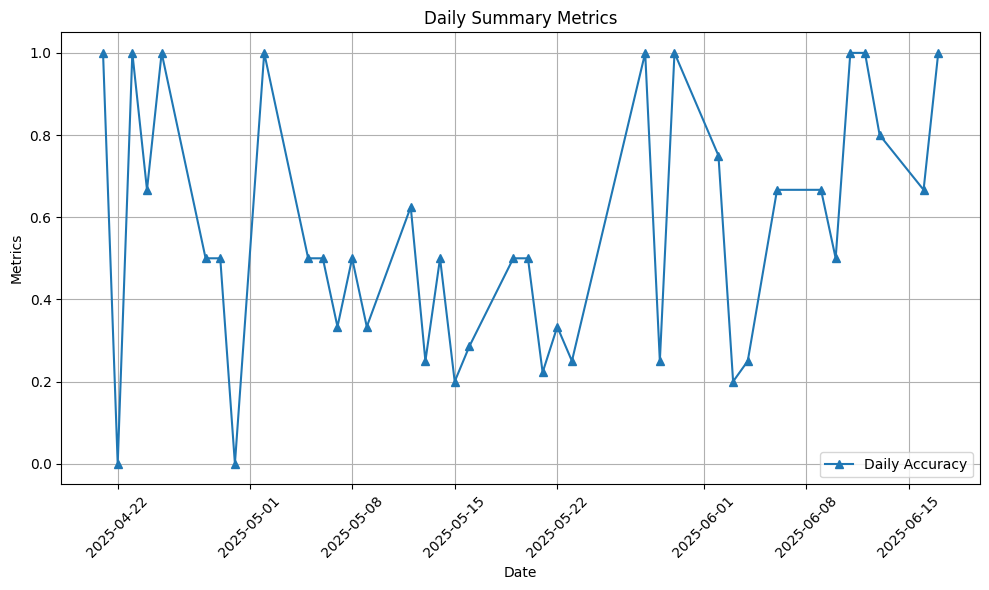

,Overall_accuracy,Overall_total_gain,Overall_avg_gain,Overall_total_gain_per_share
0,0.465278,-29.6075,-0.205608,40.7025


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_55121/771466204.py:473: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,x_bin,y
0,"(0 days 07:02:59.908999999, 0 days 08:02:04.10...",-5.4400
1,"(0 days 08:02:04.100000, 0 days 09:00:33.200000]",8.6925
2,"(0 days 09:00:33.200000, 0 days 09:59:02.300000]",-19.6700
3,"(0 days 09:59:02.300000, 0 days 10:57:31.400000]",39.4100
4,"(0 days 10:57:31.400000, 0 days 11:56:00.500000]",2.6500
5,"(0 days 11:56:00.500000, 0 days 12:54:29.600000]",9.0400
6,"(0 days 12:54:29.600000, 0 days 13:52:58.700000]",-3.4800
7,"(0 days 13:52:58.700000, 0 days 14:51:27.800000]",-131.8300
8,"(0 days 14:51:27.800000, 0 days 15:49:56.900000]",142.7700
9,"(0 days 15:49:56.900000, 0 days 16:48:26]",-1.4400


In [31]:
# Load the stock orders file
#stock_order_records = pd.read_csv("~/Downloads/Webull_Orders_Records.noOCO.csv")
buy_records ="/Users/stevensmith/Projects/Random_Projects/day_trading/data/raw_data/order_hx/Webull_Order_Records_2025_06_17.csv"
stock_order_records = pd.read_csv(buy_records)
stock_orders_formatted = format_orders(stock_order_records)
filled_orders = stock_orders_formatted[stock_orders_formatted['Status'] == 'Filled']
filled_orders_filtered = filter_stock_orders(filled_orders,days=100)

filled_orders_filtered,filled_orders_w_stats  = compute_stats_long(filled_orders_filtered)
display(filled_orders_filtered)
display(filled_orders_w_stats.sort_values(by=['Date','Symbol'],ascending=[True,True]))
filled_orders_summary= compute_summary(filled_orders_w_stats)
import matplotlib.pyplot as plt

# Plot the daily summary
daily_summary = filled_orders_summary['daily_summary'].sort_values(by='Date', ascending=True)
display(daily_summary)
plt.figure(figsize=(10, 6))
#plt.plot(daily_summary['Date'], daily_summary['Daily_total_gain'], label='Daily Total Gain', marker='o')
# plt.plot(daily_summary['Date'], daily_summary['Daily_avg_gain'], label='Daily Average Gain', marker='x')
#plt.plot(daily_summary['Date'], daily_summary['Daily_total_gain_per_share'], label='Daily Total Gain Per Share', marker='s')
plt.plot(daily_summary['Date'], daily_summary['Daily_accuracy'], label='Daily Accuracy', marker='^')

plt.xlabel('Date')
plt.ylabel('Metrics')
plt.title('Daily Summary Metrics')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
display(filled_orders_summary['overall_summary'])

filled_orders_filtered[filled_orders_filtered['Date']=="2025-05-09"]#.to_csv("filled_orders_filtered_2025-05-09.csv",index=False)']

filled_orders_filtered['FilledTime_only'] = pd.to_timedelta(filled_orders_filtered['FilledTime'].dt.time.astype(str))
#filled_orders_filtered['FilledTime_only'] = pd.to_timedelta(filled_orders_filtered['FilledTime_only'].astype(str))
bin_and_tally(filled_orders_filtered, binned_vars='FilledTime_only', binned_vals='AvgPrice', bins=10, bin_labels=None)

In [8]:
dates=daily_summary[daily_summary['Daily_total_gain']<-2]['Date']
#filled_orders_filtered[filled_orders_filtered['Date'].isin(dates)].to_csv("filled_orders_filtered_losing_days.tsv",index=False,sep="\t")
filled_orders_summary


{'daily_summary':           Date  Daily_success  Total_trades  Daily_accuracy  Daily_total_gain  \
 0   2025-04-21              1             1        1.000000            0.1000   
 1   2025-04-22              0             1        0.000000           -0.1400   
 2   2025-04-23              3             3        1.000000            1.0400   
 3   2025-04-24              2             3        0.666667            0.3600   
 4   2025-04-25              2             2        1.000000            0.6800   
 5   2025-04-28              1             2        0.500000            0.4900   
 6   2025-04-29              1             2        0.500000           -0.0700   
 7   2025-04-30              0             1        0.000000           -2.0500   
 8   2025-05-02              2             2        1.000000            0.4700   
 9   2025-05-05              2             4        0.500000            0.7200   
 10  2025-05-06              1             2        0.500000           -0.8100   

# View candle plots by themselves (optional)

Compare yFinance vs alpha advantage get stock data mode

In [ ]:
test_alpha=get_stock_data("MCTR",source="alphavantage",debug=False, start_date="2025-06-04",end_date="2025-06-06",stock_interval="1min", download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/alphavantage/MCTR_TEST_1m.tsv", api_key=ALPHA_ADVANTAGE_KEY)
test_yf=get_stock_data("MCTR",source="yfinance",debug=False, start_date="2025-06-04",end_date="2025-06-06",stock_interval="1m", download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv", api_key=ALPHA_ADVANTAGE_KEY)
display(filter_stock(test_alpha[test_alpha['stock_date']=="2025-06-05"],start_time="09:30:00", end_time="16:00:00").sort_values(by=['stock_time']))
display(test_yf[test_yf['stock_date']=="2025-06-05"].sort_values(by=['stock_time']))

Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m_dtypes.json


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/1351410899.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/1351410899.py:488: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Datetime,Open,High,Low,Close,Volume,stock_time,stock_date,Dividends,Stock Splits
1532,2025-06-05 09:30:00-04:00,20.9700,21.5900,20.850,21.2150,54717,09:30:00,2025-06-05,None,None
1531,2025-06-05 09:31:00-04:00,21.2900,21.3824,19.070,19.0720,41499,09:31:00,2025-06-05,None,None
1530,2025-06-05 09:32:00-04:00,19.0900,19.6500,18.080,18.0994,75541,09:32:00,2025-06-05,None,None
1529,2025-06-05 09:33:00-04:00,18.0900,18.6700,17.572,17.9000,76543,09:33:00,2025-06-05,None,None
1528,2025-06-05 09:34:00-04:00,17.8000,18.0000,17.150,17.1500,45024,09:34:00,2025-06-05,None,None
...,...,...,...,...,...,...,...,...,...,...
1158,2025-06-05 15:56:00-04:00,7.3100,7.3600,7.310,7.3450,17577,15:56:00,2025-06-05,None,None
1157,2025-06-05 15:57:00-04:00,7.3400,7.4300,7.335,7.3400,28863,15:57:00,2025-06-05,None,None
1156,2025-06-05 15:58:00-04:00,7.3400,7.3400,7.260,7.2750,22644,15:58:00,2025-06-05,None,None
1155,2025-06-05 15:59:00-04:00,7.2999,7.3400,7.250,7.3150,33743,15:59:00,2025-06-05,None,None


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
354,2025-06-05 09:30:00-04:00,21.000000,21.590000,20.850000,21.215000,1996705,0.0,0.0,09:30:00,2025-06-05
355,2025-06-05 09:31:00-04:00,21.290001,21.382401,19.072001,19.072001,41523,0.0,0.0,09:31:00,2025-06-05
356,2025-06-05 09:32:00-04:00,19.070000,19.639999,18.080000,18.099400,75750,0.0,0.0,09:32:00,2025-06-05
357,2025-06-05 09:33:00-04:00,18.070000,18.670000,17.572001,17.900000,75980,0.0,0.0,09:33:00,2025-06-05
358,2025-06-05 09:34:00-04:00,17.799999,18.000000,17.150000,17.150000,45846,0.0,0.0,09:34:00,2025-06-05
...,...,...,...,...,...,...,...,...,...,...
721,2025-06-05 15:55:00-04:00,7.350000,7.380000,7.330000,7.330600,10064,0.0,0.0,15:55:00,2025-06-05
722,2025-06-05 15:56:00-04:00,7.310000,7.360000,7.310000,7.345000,17667,0.0,0.0,15:56:00,2025-06-05
723,2025-06-05 15:57:00-04:00,7.340000,7.430000,7.335000,7.340000,28771,0.0,0.0,15:57:00,2025-06-05
724,2025-06-05 15:58:00-04:00,7.340000,7.340000,7.270000,7.275000,22829,0.0,0.0,15:58:00,2025-06-05


Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m_dtypes.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
354,2025-06-05 09:30:00-04:00,21.000000,21.590000,20.850000,21.215000,1996705,0.0,0.0,09:30:00,2025-06-05
355,2025-06-05 09:31:00-04:00,21.290001,21.382401,19.072001,19.072001,41523,0.0,0.0,09:31:00,2025-06-05
356,2025-06-05 09:32:00-04:00,19.070000,19.639999,18.080000,18.099400,75750,0.0,0.0,09:32:00,2025-06-05
357,2025-06-05 09:33:00-04:00,18.070000,18.670000,17.572001,17.900000,75980,0.0,0.0,09:33:00,2025-06-05
358,2025-06-05 09:34:00-04:00,17.799999,18.000000,17.150000,17.150000,45846,0.0,0.0,09:34:00,2025-06-05
359,2025-06-05 09:35:00-04:00,17.150000,17.510000,16.510000,16.510000,84134,0.0,0.0,09:35:00,2025-06-05
360,2025-06-05 09:36:00-04:00,16.510000,16.669901,16.309999,16.309999,27017,0.0,0.0,09:36:00,2025-06-05
361,2025-06-05 09:41:00-04:00,16.150000,16.870001,15.780000,16.549999,41766,0.0,0.0,09:41:00,2025-06-05
362,2025-06-05 09:42:00-04:00,16.510000,17.260000,15.720000,15.730000,83452,0.0,0.0,09:42:00,2025-06-05
363,2025-06-05 09:43:00-04:00,15.730800,15.786100,15.300000,15.485000,67291,0.0,0.0,09:43:00,2025-06-05


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID
0,Test symbol namel,TEST,Sell,Filled,1,1,@7.10,7.1,GTC,2025-05-13 13:22:30-04:00,2025-05-13 13:22:30-04:00,2025-05-13,13:22:30,TEST_2025-05-13 13:22:30-04:00


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date,...,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID
0,2025-06-05 09:30:00-04:00,21.000000,21.590000,20.850000,21.215000,1996705,0.0,0.0,09:30:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
1,2025-06-05 09:31:00-04:00,21.290001,21.382401,19.072001,19.072001,41523,0.0,0.0,09:31:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
2,2025-06-05 09:32:00-04:00,19.070000,19.639999,18.080000,18.099400,75750,0.0,0.0,09:32:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
3,2025-06-05 09:33:00-04:00,18.070000,18.670000,17.572001,17.900000,75980,0.0,0.0,09:33:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
4,2025-06-05 09:34:00-04:00,17.799999,18.000000,17.150000,17.150000,45846,0.0,0.0,09:34:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
5,2025-06-05 09:35:00-04:00,17.150000,17.510000,16.510000,16.510000,84134,0.0,0.0,09:35:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
6,2025-06-05 09:36:00-04:00,16.510000,16.669901,16.309999,16.309999,27017,0.0,0.0,09:36:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
7,2025-06-05 09:41:00-04:00,16.150000,16.870001,15.780000,16.549999,41766,0.0,0.0,09:41:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
8,2025-06-05 09:42:00-04:00,16.510000,17.260000,15.720000,15.730000,83452,0.0,0.0,09:42:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
9,2025-06-05 09:43:00-04:00,15.730800,15.786100,15.300000,15.485000,67291,0.0,0.0,09:43:00,2025-06-05,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN


/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-05_MCTR_1.0mins.png
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 47 rows containing missing values.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 47 rows containing missing values.


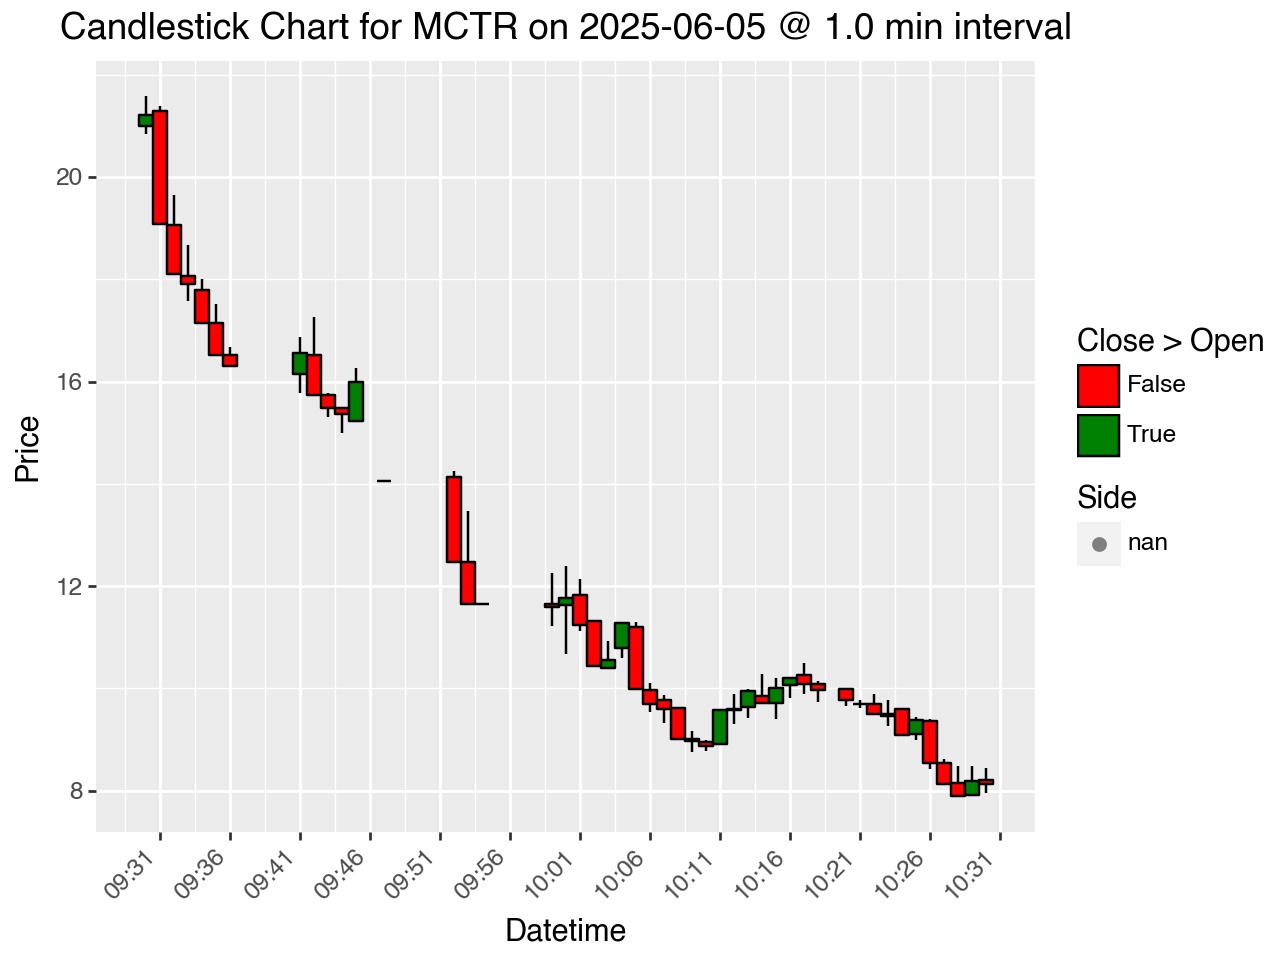

In [219]:
# plot a given Stock's candlestick chart with buy/sell orders, using an empty order file as the joined orders
#tmp=get_stock_data_alpha("MCTR",  stock_interval="1min", download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/MCTR_TEST_1m.tsv", api_key=ALPHA_ADVANTAGE_KEY)
#tmp.to_csv("/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/MCTR_TEST_1m.tsv", index=False, sep="\t")
#test2=get_stock_data("MCTR",  source="alphavantage",debug=True, stock_interval="1min", download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/alphavantage/MCTR_TEST_1m.tsv", api_key=ALPHA_ADVANTAGE_KEY)

test1=get_stock_data("MCTR",source="yfinance",debug=True, start_date="2025-06-04",end_date="2025-06-06",stock_interval="1m", download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv", api_key=ALPHA_ADVANTAGE_KEY)
tmp_filt2= filter_stock(test1, start_time="09:30:00", end_time="10:30:00", time_column='Datetime')
tmp_filt2=tmp_filt2[tmp_filt2['stock_date']=="2025-06-05"]

#tmp.to_csv("tmp_filtered.csv",index=False,sep="\t")

test_records = pd.read_csv("/Users/stevensmith/Projects/Random_Projects/stock_reccomender/empty_order.tsv")
stock_orders_empty = format_orders(test_records)

tmp2 = combine_data(tmp_filt2,stock_orders_empty,direction='backward',stock_key='Datetime', order_key='FilledTime')
display(tmp2)

generate_candlestick_plot(tmp2, timedata_width=0.5, date="2025-06-05", stock_symbol="MCTR")


Get historical stock data


# Compare with stock price

In [291]:
t1=get_stock_data_wrapper(symbol="MCTR",source="alphavantage",debug=True,load_from_file="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv", start_date="2025-06-04",end_date="2025-06-06",stock_interval="1m", download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/alphavantage/MCTR_TEST_1m.tsv", api_key=ALPHA_ADVANTAGE_KEY)

# dtypes_dict_global = {'Datetime': 'datetime64[ns, America/New_York]',
#                                   'Open': 'float64',
#                                     'High': 'float64',
#                                     'Low': 'float64',
#                                     'Close': 'float64',
#                                     'Volume': 'int64',
#                                     'Dividends': 'float64',
#                                     'Stock Splits': 'float64',
#                                     "stock_time": "object",
#                                     "stock_date": "datetime64[ns]"
#                                     }

# t1 = t1.astype(dtypes_dict_global)
t1

{'Datetime': 'datetime64[ns, America/New_York]', 'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 'Volume': 'int64', 'Dividends': 'float64', 'Stock Splits': 'float64', 'stock_time': 'object', 'stock_date': 'datetime64[ns]'}
reloading data with dtypes


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-04 09:30:00-04:00,38.520000,41.000000,38.200001,39.660000,2389066,0.0,0.0,09:30:00,2025-06-04
1,2025-06-04 09:31:00-04:00,40.090000,42.000000,39.660000,41.389999,88605,0.0,0.0,09:31:00,2025-06-04
2,2025-06-04 09:32:00-04:00,41.110001,44.950001,41.110001,43.379902,195693,0.0,0.0,09:32:00,2025-06-04
3,2025-06-04 09:33:00-04:00,43.379902,44.599998,42.020000,42.380001,143279,0.0,0.0,09:33:00,2025-06-04
4,2025-06-04 09:34:00-04:00,42.930000,47.389999,42.360001,45.810001,245903,0.0,0.0,09:34:00,2025-06-04
...,...,...,...,...,...,...,...,...,...,...
721,2025-06-05 15:55:00-04:00,7.350000,7.380000,7.330000,7.330600,10064,0.0,0.0,15:55:00,2025-06-05
722,2025-06-05 15:56:00-04:00,7.310000,7.360000,7.310000,7.345000,17667,0.0,0.0,15:56:00,2025-06-05
723,2025-06-05 15:57:00-04:00,7.340000,7.430000,7.335000,7.340000,28771,0.0,0.0,15:57:00,2025-06-05
724,2025-06-05 15:58:00-04:00,7.340000,7.340000,7.270000,7.275000,22829,0.0,0.0,15:58:00,2025-06-05


In [304]:
get_stock_data_wrapper(stmbol="MCTR",
                       source = "yfinance", 
                       start_date="2025-06-04", 
                       end_date="2025-06-05", 
                       stock_interval="1m",
                       download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv", dl_info=True,
                       load_from_file="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv",api_key=ALPHA_ADVANTAGE_KEY,debug=True)


get_stock_data_wrapper(stmbol="MCTR",
                                           source =  "yfinance", 
                                           start_date="2025-06-04", 
                                           end_date="2025-06-05", 
                                           stock_interval="1m",
                                           download_file_path="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv", 
                                           dl_info=True,
                                           load_from_file="/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/MCTR_TEST_1m.tsv",
                                           api_key=ALPHA_ADVANTAGE_KEY,
                                           debug=True)

{'Datetime': 'datetime64[ns, America/New_York]', 'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 'Volume': 'int64', 'Dividends': 'float64', 'Stock Splits': 'float64', 'stock_time': 'object', 'stock_date': 'datetime64[ns]'}
reloading data with dtypes
{'Datetime': 'datetime64[ns, America/New_York]', 'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 'Volume': 'int64', 'Dividends': 'float64', 'Stock Splits': 'float64', 'stock_time': 'object', 'stock_date': 'datetime64[ns]'}
reloading data with dtypes


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-04 09:30:00-04:00,38.520000,41.000000,38.200001,39.660000,2389066,0.0,0.0,09:30:00,2025-06-04
1,2025-06-04 09:31:00-04:00,40.090000,42.000000,39.660000,41.389999,88605,0.0,0.0,09:31:00,2025-06-04
2,2025-06-04 09:32:00-04:00,41.110001,44.950001,41.110001,43.379902,195693,0.0,0.0,09:32:00,2025-06-04
3,2025-06-04 09:33:00-04:00,43.379902,44.599998,42.020000,42.380001,143279,0.0,0.0,09:33:00,2025-06-04
4,2025-06-04 09:34:00-04:00,42.930000,47.389999,42.360001,45.810001,245903,0.0,0.0,09:34:00,2025-06-04
...,...,...,...,...,...,...,...,...,...,...
721,2025-06-05 15:55:00-04:00,7.350000,7.380000,7.330000,7.330600,10064,0.0,0.0,15:55:00,2025-06-05
722,2025-06-05 15:56:00-04:00,7.310000,7.360000,7.310000,7.345000,17667,0.0,0.0,15:56:00,2025-06-05
723,2025-06-05 15:57:00-04:00,7.340000,7.430000,7.335000,7.340000,28771,0.0,0.0,15:57:00,2025-06-05
724,2025-06-05 15:58:00-04:00,7.340000,7.340000,7.270000,7.275000,22829,0.0,0.0,15:58:00,2025-06-05


In [306]:
#TODO: alpha vantage downloads all data up until the date it was dwnloaded. It also imposes a 25 call limit per day. Need to be smart about re-loading data if it exists for a given date.  
data_source = "yfinance"
dates = filter_stock_orders(filled_orders_filtered,days=10)['Date'].unique()
tmp1 = tmp2 = ""
#dates = filled_orders_w_stats_mlindx[('Date',)  ].unique()
for start_date in dates:
    # Filter the DataFrame for the current date
    #filtered_df = filled_orders_filtered[filled_orders_filtered['FilledTime'].dt.date == start_date]
    filtered_df = filled_orders_filtered[filled_orders_filtered['Date'] == start_date]
    
    for selected_symbol in filtered_df['Symbol'].unique():
        #print(f"Orders for {selected_symbol}:")
        filtered_synbol_date_df = filtered_df[filtered_df['Symbol'] == selected_symbol]
        end_date = start_date + pd.Timedelta(days=1)

        interval_mins = 1 # TODO: make this a parameter/data validation

        if data_source == "yfinance":
            interval = f"{interval_mins}m"
        elif data_source == "alphavantage":
            interval = f"{interval_mins}min"
        else:

            raise ValueError(f"Check data_source variabke: {interval_mins} minutes")
        
        stock_fn = f"/Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/{data_source}/stock_order_{start_date}_{selected_symbol}_{interval}.tsv"

        # SWAP OUT FOR ALPHA VANTAGE
        stock_dat = get_stock_data_wrapper(symbol=selected_symbol,
                                           source = data_source, 
                                           start_date=start_date, 
                                           end_date=end_date, 
                                           stock_interval=interval,
                                           download_file_path=stock_fn, 
                                           dl_info=True,
                                           load_from_file=stock_fn,
                                           api_key=ALPHA_ADVANTAGE_KEY,
                                           debug=True)
        #stock_dat = get_stock_data_alpha(selected_symbol, stock_interval=interval,api_key=ALPHA_ADVANTAGE_KEY,download_file_path=stock_fn)#,load_from_file=stock_fn)

        #filled_orders[filled_orders['Symbol']==selected_symbol].to_csv(f"stock_order_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")
        #TODO: fix loading from previous file. I think the date/time format is not being correctly loaded
        tmp1 = stock_dat
        tmp2 = filtered_synbol_date_df


        stock_order_df = combine_data(stock_dat, filtered_synbol_date_df,tol_interval=interval,direction='backward',stock_key='Datetime', order_key='FilledTime')

        if stock_order_df is not None:

            stock_order_df.loc[stock_order_df['Side']=='Buy','AvgPrice'] = -stock_order_df.loc[stock_order_df['Side']=='Buy','AvgPrice']

            stock_order_df.to_csv(f"stock_order_price_df_{start_date}_{selected_symbol}.tsv", index=False,sep="\t")

            generate_candlestick_plot(filter_time_window(stock_order_df),timedata_width=interval_mins/2,date=start_date ,stock_symbol=selected_symbol)
        else:
            print(f"Stock data for {selected_symbol} on {start_date} not found. Skipping candlestick plot generation.")
            continue


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_CRCL_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.
Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_CRCL_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_CRCL_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_CRCL_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-06 09:30:00-04:00,97.999001,99.879997,97.019997,99.879997,5537263,0.0,0.0,09:30:00,2025-06-06
1,2025-06-06 09:31:00-04:00,99.888901,103.900002,96.400002,98.360001,1074969,0.0,0.0,09:31:00,2025-06-06
2,2025-06-06 09:32:00-04:00,98.709999,98.709999,96.300003,97.790001,354880,0.0,0.0,09:32:00,2025-06-06
3,2025-06-06 09:33:00-04:00,97.650002,99.290001,97.540001,98.735001,329803,0.0,0.0,09:33:00,2025-06-06
4,2025-06-06 09:34:00-04:00,98.790001,99.040001,95.510002,95.510002,352142,0.0,0.0,09:34:00,2025-06-06
...,...,...,...,...,...,...,...,...,...,...
380,2025-06-06 15:55:00-04:00,110.239998,110.370003,108.629997,108.629997,118499,0.0,0.0,15:55:00,2025-06-06
381,2025-06-06 15:56:00-04:00,108.995003,109.129997,107.000000,107.000000,182770,0.0,0.0,15:56:00,2025-06-06
382,2025-06-06 15:57:00-04:00,107.000000,107.919998,106.199997,107.400002,253232,0.0,0.0,15:57:00,2025-06-06
383,2025-06-06 15:58:00-04:00,107.260002,107.709999,106.419998,107.695000,176431,0.0,0.0,15:58:00,2025-06-06


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
8,CIRCLE INTERNET GROUP INC,CRCL,Buy,Filled,1,1,@97.66,-97.66,GTC,2025-06-06 09:29:42-04:00,2025-06-06 09:29:42-04:00,2025-06-06,09:29:42,CRCL_2025-06-06 09:29:42-04:00,-97.66,0 days 09:29:42
6,CIRCLE INTERNET GROUP INC,CRCL,Sell,Filled,1,1,@96.37,96.37,GTC,2025-06-06 09:29:52-04:00,2025-06-06 09:29:52-04:00,2025-06-06,09:29:52,CRCL_2025-06-06 09:29:52-04:00,96.37,0 days 09:29:52
3,CIRCLE INTERNET GROUP INC,CRCL,Buy,Filled,1,1,@98.45,-98.45,GTC,2025-06-06 09:30:48-04:00,2025-06-06 09:30:48-04:00,2025-06-06,09:30:48,CRCL_2025-06-06 09:30:48-04:00,-98.45,0 days 09:30:48
0,CIRCLE INTERNET GROUP INC,CRCL,Sell,Filled,1,1,@100.37,100.37,GTC,2025-06-06 09:31:09-04:00,2025-06-06 09:31:09-04:00,2025-06-06,09:31:09,CRCL_2025-06-06 09:31:09-04:00,100.37,0 days 09:31:09


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-06_CRCL_1.0mins.png
/Users/stevensmith/Projects/python

File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VERO_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.
Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VERO_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VERO_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VERO_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-06 09:30:00-04:00,3.9000,4.0700,3.8300,3.9799,31895382,0.0,0.0,09:30:00,2025-06-06
1,2025-06-06 09:31:00-04:00,4.0400,4.2000,4.0400,4.0999,1058335,0.0,0.0,09:31:00,2025-06-06
2,2025-06-06 09:32:00-04:00,4.0997,4.2199,3.9700,4.1700,945602,0.0,0.0,09:32:00,2025-06-06
3,2025-06-06 09:33:00-04:00,4.1799,4.2500,4.0000,4.0100,1088735,0.0,0.0,09:33:00,2025-06-06
4,2025-06-06 09:34:00-04:00,4.0167,4.1900,3.9500,4.1200,891248,0.0,0.0,09:34:00,2025-06-06
...,...,...,...,...,...,...,...,...,...,...
379,2025-06-06 15:55:00-04:00,3.1550,3.1608,3.1100,3.1300,44700,0.0,0.0,15:55:00,2025-06-06
380,2025-06-06 15:56:00-04:00,3.1399,3.1399,3.1000,3.1118,39943,0.0,0.0,15:56:00,2025-06-06
381,2025-06-06 15:57:00-04:00,3.1100,3.1400,3.1004,3.1399,44013,0.0,0.0,15:57:00,2025-06-06
382,2025-06-06 15:58:00-04:00,3.1350,3.1650,3.1300,3.1529,35128,0.0,0.0,15:58:00,2025-06-06


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
5,Venus Concept Inc,VERO,Buy,Filled,1,1,@4.02,-4.02,GTC,2025-06-06 09:30:26-04:00,2025-06-06 09:30:26-04:00,2025-06-06,09:30:26,VERO_2025-06-06 09:30:26-04:00,-4.02,0 days 09:30:26
4,Venus Concept Inc,VERO,Sell,Filled,1,1,@3.94,3.94,GTC,2025-06-06 09:30:31-04:00,2025-06-06 09:30:31-04:00,2025-06-06,09:30:31,VERO_2025-06-06 09:30:31-04:00,3.94,0 days 09:30:31


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VEEE_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-06_VERO_1.0mins.png
/Users/stevensmith/Projects/python

Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VEEE_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VEEE_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-06_VEEE_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-06 09:30:00-04:00,2.5800,2.58,2.5100,2.5400,12765841,0.0,0.0,09:30:00,2025-06-06
1,2025-06-06 09:31:00-04:00,2.5500,2.57,2.5000,2.5101,67587,0.0,0.0,09:31:00,2025-06-06
2,2025-06-06 09:32:00-04:00,2.5200,2.52,2.4101,2.4500,97121,0.0,0.0,09:32:00,2025-06-06
3,2025-06-06 09:33:00-04:00,2.4600,2.47,2.4300,2.4700,44759,0.0,0.0,09:33:00,2025-06-06
4,2025-06-06 09:34:00-04:00,2.4698,2.48,2.4600,2.4697,20292,0.0,0.0,09:34:00,2025-06-06
...,...,...,...,...,...,...,...,...,...,...
305,2025-06-06 15:55:00-04:00,2.4600,2.46,2.4200,2.4200,6960,0.0,0.0,15:55:00,2025-06-06
306,2025-06-06 15:56:00-04:00,2.4500,2.45,2.4350,2.4400,8659,0.0,0.0,15:56:00,2025-06-06
307,2025-06-06 15:57:00-04:00,2.4500,2.45,2.4200,2.4200,14511,0.0,0.0,15:57:00,2025-06-06
308,2025-06-06 15:58:00-04:00,2.4400,2.48,2.4200,2.4200,14948,0.0,0.0,15:58:00,2025-06-06


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
12,Twin Vee Powercats Co,VEEE,Buy,Filled,1,1,@3.21,-3.21,GTC,2025-06-06 08:03:16-04:00,2025-06-06 08:03:16-04:00,2025-06-06,08:03:16,VEEE_2025-06-06 08:03:16-04:00,-3.21,0 days 08:03:16
11,Twin Vee Powercats Co,VEEE,Sell,Filled,1,1,@3.23,3.23,GTC,2025-06-06 08:03:26-04:00,2025-06-06 08:03:26-04:00,2025-06-06,08:03:26,VEEE_2025-06-06 08:03:26-04:00,3.23,0 days 08:03:26
10,Twin Vee Powercats Co,VEEE,Buy,Filled,1,1,@3.04,-3.04,GTC,2025-06-06 08:23:42-04:00,2025-06-06 08:23:42-04:00,2025-06-06,08:23:42,VEEE_2025-06-06 08:23:42-04:00,-3.04,0 days 08:23:42
9,Twin Vee Powercats Co,VEEE,Sell,Filled,1,1,@3.07,3.07,GTC,2025-06-06 08:24:14-04:00,2025-06-06 08:24:14-04:00,2025-06-06,08:24:14,VEEE_2025-06-06 08:24:14-04:00,3.07,0 days 08:24:14


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MFI_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-06_VEEE_1.0mins.png


Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MFI_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MFI_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MFI_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-04 09:30:00-04:00,1.130,1.2000,1.1300,1.2000,10739,0.0,0.0,09:30:00,2025-06-04
1,2025-06-04 09:32:00-04:00,1.170,1.2000,1.1100,1.1100,3021,0.0,0.0,09:32:00,2025-06-04
2,2025-06-04 09:33:00-04:00,1.200,1.2000,1.1200,1.1200,502,0.0,0.0,09:33:00,2025-06-04
3,2025-06-04 09:34:00-04:00,1.122,1.1300,1.1220,1.1300,1100,0.0,0.0,09:34:00,2025-06-04
4,2025-06-04 09:36:00-04:00,1.130,1.1300,1.1200,1.1200,8264,0.0,0.0,09:36:00,2025-06-04
...,...,...,...,...,...,...,...,...,...,...
355,2025-06-04 15:55:00-04:00,2.115,2.1200,2.0297,2.0499,45171,0.0,0.0,15:55:00,2025-06-04
356,2025-06-04 15:56:00-04:00,2.040,2.0479,1.9450,1.9450,103753,0.0,0.0,15:56:00,2025-06-04
357,2025-06-04 15:57:00-04:00,1.940,2.0400,1.9100,1.9808,182743,0.0,0.0,15:57:00,2025-06-04
358,2025-06-04 15:58:00-04:00,1.960,2.0000,1.9100,1.9400,81110,0.0,0.0,15:58:00,2025-06-04


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
15,mF International Ltd,MFI,Buy,Filled,1,1,@2.34,-2.34,GTC,2025-06-04 15:21:54-04:00,2025-06-04 15:21:54-04:00,2025-06-04,15:21:54,MFI_2025-06-04 15:21:54-04:00,-2.34,0 days 15:21:54
14,mF International Ltd,MFI,Sell,Filled,1,1,@2.35,2.35,GTC,2025-06-04 15:21:58-04:00,2025-06-04 15:21:58-04:00,2025-06-04,15:21:58,MFI_2025-06-04 15:21:58-04:00,2.35,0 days 15:21:58


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-04_MFI_1.0mins.png
/Users/stevensmith/Projects/python_

File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_STSS_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.
Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_STSS_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_STSS_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_STSS_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-04 09:30:00-04:00,5.8403,6.1699,5.7000,6.1694,18546111,0.0,0.0,09:30:00,2025-06-04
1,2025-06-04 09:31:00-04:00,6.1400,6.3399,5.7500,5.8350,428940,0.0,0.0,09:31:00,2025-06-04
2,2025-06-04 09:32:00-04:00,5.8300,6.1700,5.7500,5.8900,330283,0.0,0.0,09:32:00,2025-06-04
3,2025-06-04 09:33:00-04:00,5.9314,5.9799,5.6500,5.8632,175930,0.0,0.0,09:33:00,2025-06-04
4,2025-06-04 09:34:00-04:00,5.8300,5.9100,5.6200,5.6600,137025,0.0,0.0,09:34:00,2025-06-04
...,...,...,...,...,...,...,...,...,...,...
381,2025-06-04 15:55:00-04:00,6.1000,6.1900,6.1000,6.1900,18571,0.0,0.0,15:55:00,2025-06-04
382,2025-06-04 15:56:00-04:00,6.1400,6.1899,6.0800,6.1200,15368,0.0,0.0,15:56:00,2025-06-04
383,2025-06-04 15:57:00-04:00,6.1400,6.1900,6.0800,6.1700,17415,0.0,0.0,15:57:00,2025-06-04
384,2025-06-04 15:58:00-04:00,6.0900,6.2100,6.0801,6.2000,51229,0.0,0.0,15:58:00,2025-06-04


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
19,Sharps Tech,STSS,Buy,Filled,1,1,@6.77,-6.77,GTC,2025-06-04 07:20:36-04:00,2025-06-04 07:20:36-04:00,2025-06-04,07:20:36,STSS_2025-06-04 07:20:36-04:00,-6.77,0 days 07:20:36
18,Sharps Tech,STSS,Sell,Filled,1,1,@6.79,6.79,GTC,2025-06-04 07:20:43-04:00,2025-06-04 07:20:43-04:00,2025-06-04,07:20:43,STSS_2025-06-04 07:20:43-04:00,6.79,0 days 07:20:43
17,Sharps Tech,STSS,Buy,Filled,1,1,@6.88,-6.88,GTC,2025-06-04 07:21:12-04:00,2025-06-04 07:21:12-04:00,2025-06-04,07:21:12,STSS_2025-06-04 07:21:12-04:00,-6.88,0 days 07:21:12
16,Sharps Tech,STSS,Sell,Filled,1,1,@6.72,6.72,GTC,2025-06-04 07:21:18-04:00,2025-06-04 07:21:18-04:00,2025-06-04,07:21:18,STSS_2025-06-04 07:21:18-04:00,6.72,0 days 07:21:18


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_NCEW_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-04_STSS_1.0mins.png


Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_NCEW_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_NCEW_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_NCEW_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-04 09:30:00-04:00,1.560,1.6500,1.5600,1.6408,29737712,0.0,0.0,09:30:00,2025-06-04
1,2025-06-04 09:31:00-04:00,1.640,1.6500,1.5650,1.5850,142289,0.0,0.0,09:31:00,2025-06-04
2,2025-06-04 09:32:00-04:00,1.589,1.6183,1.5400,1.5416,192488,0.0,0.0,09:32:00,2025-06-04
3,2025-06-04 09:33:00-04:00,1.540,1.5700,1.5200,1.5200,173083,0.0,0.0,09:33:00,2025-06-04
4,2025-06-04 09:34:00-04:00,1.520,1.5250,1.4400,1.4650,410469,0.0,0.0,09:34:00,2025-06-04
...,...,...,...,...,...,...,...,...,...,...
375,2025-06-04 15:55:00-04:00,1.385,1.3900,1.3800,1.3800,6720,0.0,0.0,15:55:00,2025-06-04
376,2025-06-04 15:56:00-04:00,1.385,1.3850,1.3500,1.3600,17654,0.0,0.0,15:56:00,2025-06-04
377,2025-06-04 15:57:00-04:00,1.365,1.3700,1.3601,1.3685,6903,0.0,0.0,15:57:00,2025-06-04
378,2025-06-04 15:58:00-04:00,1.360,1.3800,1.3550,1.3800,24374,0.0,0.0,15:58:00,2025-06-04


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
23,NEW CENTY LOGISTICS BVI LTD,NCEW,Buy,Filled,2,2,@2.13,-2.13,GTC,2025-06-04 07:09:48-04:00,2025-06-04 07:09:48-04:00,2025-06-04,07:09:48,NCEW_2025-06-04 07:09:48-04:00,-4.26,0 days 07:09:48
21,NEW CENTY LOGISTICS BVI LTD,NCEW,Sell,Filled,1,1,@1.85,1.85,GTC,2025-06-04 07:10:18-04:00,2025-06-04 07:10:18-04:00,2025-06-04,07:10:18,NCEW_2025-06-04 07:10:18-04:00,1.85,0 days 07:10:18
20,NEW CENTY LOGISTICS BVI LTD,NCEW,Sell,Filled,1,1,@1.85,1.85,GTC,2025-06-04 07:10:29-04:00,2025-06-04 07:10:29-04:00,2025-06-04,07:10:29,NCEW_2025-06-04 07:10:29-04:00,1.85,0 days 07:10:29


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MCTR_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-04_NCEW_1.0mins.png


Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MCTR_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MCTR_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-04_MCTR_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-04 09:30:00-04:00,38.520000,41.000000,38.200001,39.660000,2389066,0.0,0.0,09:30:00,2025-06-04
1,2025-06-04 09:31:00-04:00,40.090000,42.000000,39.660000,41.389999,88605,0.0,0.0,09:31:00,2025-06-04
2,2025-06-04 09:32:00-04:00,43.379902,43.379902,43.379902,43.379902,194137,0.0,0.0,09:32:00,2025-06-04
3,2025-06-04 09:33:00-04:00,43.379902,44.599998,42.020000,42.380001,144835,0.0,0.0,09:33:00,2025-06-04
4,2025-06-04 09:34:00-04:00,42.930000,47.389999,42.360001,45.810001,245903,0.0,0.0,09:34:00,2025-06-04
...,...,...,...,...,...,...,...,...,...,...
353,2025-06-04 15:55:00-04:00,15.589500,15.980000,15.200000,15.200000,36852,0.0,0.0,15:55:00,2025-06-04
354,2025-06-04 15:56:00-04:00,15.212600,15.470000,14.750100,15.210000,24541,0.0,0.0,15:56:00,2025-06-04
355,2025-06-04 15:57:00-04:00,15.270000,15.440000,15.150000,15.150000,13626,0.0,0.0,15:57:00,2025-06-04
356,2025-06-04 15:58:00-04:00,15.160000,15.699900,15.155500,15.613200,19709,0.0,0.0,15:58:00,2025-06-04


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
25,CTRL Group Ltd,MCTR,Buy,Filled,1,1,@40.75,-40.75,GTC,2025-06-04 07:03:35-04:00,2025-06-04 07:03:35-04:00,2025-06-04,07:03:35,MCTR_2025-06-04 07:03:35-04:00,-40.75,0 days 07:03:35
24,CTRL Group Ltd,MCTR,Sell,Filled,1,1,@39.10,39.10,GTC,2025-06-04 07:04:29-04:00,2025-06-04 07:04:30-04:00,2025-06-04,07:04:29,MCTR_2025-06-04 07:04:29-04:00,39.10,0 days 07:04:30


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_MCTR_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-04_MCTR_1.0mins.png


Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_MCTR_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_MCTR_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_MCTR_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-03 09:30:00-04:00,7.110000,7.910000,6.940000,7.900000,3482389,0.0,0.0,09:30:00,2025-06-03
1,2025-06-03 09:31:00-04:00,8.450000,8.450000,7.450000,8.450000,244475,0.0,0.0,09:31:00,2025-06-03
2,2025-06-03 09:36:00-04:00,8.290000,8.380000,8.150000,8.150000,53192,0.0,0.0,09:36:00,2025-06-03
3,2025-06-03 09:37:00-04:00,8.100000,8.950000,7.600000,8.600000,601238,0.0,0.0,09:37:00,2025-06-03
4,2025-06-03 09:38:00-04:00,8.600000,8.600000,7.890000,8.040000,248466,0.0,0.0,09:38:00,2025-06-03
...,...,...,...,...,...,...,...,...,...,...
298,2025-06-03 15:44:00-04:00,29.834999,29.910000,29.299999,29.330000,26389,0.0,0.0,15:44:00,2025-06-03
299,2025-06-03 15:45:00-04:00,29.219999,29.219999,27.480000,28.299999,87298,0.0,0.0,15:45:00,2025-06-03
300,2025-06-03 15:46:00-04:00,28.299999,29.370001,28.120001,28.730101,37663,0.0,0.0,15:46:00,2025-06-03
301,2025-06-03 15:47:00-04:00,28.865000,30.500000,28.865000,30.500000,96448,0.0,0.0,15:47:00,2025-06-03


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
34,CTRL Group Ltd,MCTR,Buy,Filled,1,1,@13.69,-13.69,GTC,2025-06-03 12:57:47-04:00,2025-06-03 12:57:47-04:00,2025-06-03,12:57:47,MCTR_2025-06-03 12:57:47-04:00,-13.69,0 days 12:57:47
33,CTRL Group Ltd,MCTR,Sell,Filled,1,1,@13.78,13.78,GTC,2025-06-03 12:57:50-04:00,2025-06-03 12:57:50-04:00,2025-06-03,12:57:50,MCTR_2025-06-03 12:57:50-04:00,13.78,0 days 12:57:50
32,CTRL Group Ltd,MCTR,Buy,Filled,1,1,@14.78,-14.78,GTC,2025-06-03 13:16:13-04:00,2025-06-03 13:16:13-04:00,2025-06-03,13:16:13,MCTR_2025-06-03 13:16:13-04:00,-14.78,0 days 13:16:13
31,CTRL Group Ltd,MCTR,Sell,Filled,1,1,@14.79,14.79,GTC,2025-06-03 13:16:17-04:00,2025-06-03 13:16:17-04:00,2025-06-03,13:16:17,MCTR_2025-06-03 13:16:17-04:00,14.79,0 days 13:16:17
30,CTRL Group Ltd,MCTR,Buy,Filled,1,1,@31.75,-31.75,GTC,2025-06-03 15:08:33-04:00,2025-06-03 15:08:34-04:00,2025-06-03,15:08:33,MCTR_2025-06-03 15:08:33-04:00,-31.75,0 days 15:08:34
29,CTRL Group Ltd,MCTR,Sell,Filled,1,1,@31.52,31.52,GTC,2025-06-03 15:08:40-04:00,2025-06-03 15:08:40-04:00,2025-06-03,15:08:40,MCTR_2025-06-03 15:08:40-04:00,31.52,0 days 15:08:40
28,CTRL Group Ltd,MCTR,Buy,Filled,1,1,@31.84,-31.84,GTC,2025-06-03 15:20:08-04:00,2025-06-03 15:20:08-04:00,2025-06-03,15:20:08,MCTR_2025-06-03 15:20:08-04:00,-31.84,0 days 15:20:08
27,CTRL Group Ltd,MCTR,Sell,Filled,1,1,@29.70,29.70,DAY,2025-06-03 15:20:33-04:00,2025-06-03 15:21:50-04:00,2025-06-03,15:20:33,MCTR_2025-06-03 15:20:33-04:00,29.70,0 days 15:21:50


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-03_MCTR_1.0mins.png
/Users/stevensmith/Projects/python

File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_RSLS_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.
Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_RSLS_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_RSLS_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_RSLS_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-03 09:30:00-04:00,5.7000,5.7100,5.4601,5.5279,12630180,0.0,0.0,09:30:00,2025-06-03
1,2025-06-03 09:31:00-04:00,5.5140,5.5199,5.0000,5.3400,274131,0.0,0.0,09:31:00,2025-06-03
2,2025-06-03 09:32:00-04:00,5.2949,5.5300,5.1200,5.4690,118167,0.0,0.0,09:32:00,2025-06-03
3,2025-06-03 09:33:00-04:00,5.4450,5.5300,5.3101,5.3601,83409,0.0,0.0,09:33:00,2025-06-03
4,2025-06-03 09:34:00-04:00,5.3601,5.3900,5.2100,5.3500,71850,0.0,0.0,09:34:00,2025-06-03
...,...,...,...,...,...,...,...,...,...,...
383,2025-06-03 15:55:00-04:00,6.8700,7.0590,6.7700,6.9350,112369,0.0,0.0,15:55:00,2025-06-03
384,2025-06-03 15:56:00-04:00,6.9200,7.0000,6.9100,6.9600,39087,0.0,0.0,15:56:00,2025-06-03
385,2025-06-03 15:57:00-04:00,6.9700,6.9700,6.6100,6.7900,69776,0.0,0.0,15:57:00,2025-06-03
386,2025-06-03 15:58:00-04:00,6.7500,6.8900,6.7500,6.7700,35406,0.0,0.0,15:58:00,2025-06-03


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
59,Reshape Lifesciences Inc.,RSLS,Buy,Filled,1,1,@8.16,-8.16,GTC,2025-06-03 08:51:31-04:00,2025-06-03 08:51:31-04:00,2025-06-03,08:51:31,RSLS_2025-06-03 08:51:31-04:00,-8.16,0 days 08:51:31
58,Reshape Lifesciences Inc.,RSLS,Sell,Filled,1,1,@8.16,8.16,GTC,2025-06-03 08:51:46-04:00,2025-06-03 08:51:46-04:00,2025-06-03,08:51:46,RSLS_2025-06-03 08:51:46-04:00,8.16,0 days 08:51:46
57,Reshape Lifesciences Inc.,RSLS,Buy,Filled,1,1,@8.18,-8.18,GTC,2025-06-03 08:52:02-04:00,2025-06-03 08:52:02-04:00,2025-06-03,08:52:02,RSLS_2025-06-03 08:52:02-04:00,-8.18,0 days 08:52:02
56,Reshape Lifesciences Inc.,RSLS,Sell,Filled,1,1,@8.00,8.00,GTC,2025-06-03 08:52:36-04:00,2025-06-03 08:52:36-04:00,2025-06-03,08:52:36,RSLS_2025-06-03 08:52:36-04:00,8.00,0 days 08:52:36
52,Reshape Lifesciences Inc.,RSLS,Buy,Filled,1,1,@5.77,-5.77,GTC,2025-06-03 09:46:46-04:00,2025-06-03 09:46:46-04:00,2025-06-03,09:46:46,RSLS_2025-06-03 09:46:46-04:00,-5.77,0 days 09:46:46
49,Reshape Lifesciences Inc.,RSLS,Sell,Filled,1,1,@6.02,6.02,GTC,2025-06-03 09:48:30-04:00,2025-06-03 09:48:30-04:00,2025-06-03,09:48:30,RSLS_2025-06-03 09:48:30-04:00,6.02,0 days 09:48:30
48,Reshape Lifesciences Inc.,RSLS,Buy,Filled,1,1,@6.25,-6.25,GTC,2025-06-03 09:50:20-04:00,2025-06-03 09:50:20-04:00,2025-06-03,09:50:20,RSLS_2025-06-03 09:50:20-04:00,-6.25,0 days 09:50:20
45,Reshape Lifesciences Inc.,RSLS,Sell,Filled,1,1,@6.12,6.12,GTC,2025-06-03 09:56:13-04:00,2025-06-03 09:56:13-04:00,2025-06-03,09:56:13,RSLS_2025-06-03 09:56:13-04:00,6.12,0 days 09:56:13
44,Reshape Lifesciences Inc.,RSLS,Buy,Filled,1,1,@6.40,-6.40,GTC,2025-06-03 09:56:49-04:00,2025-06-03 09:56:50-04:00,2025-06-03,09:56:49,RSLS_2025-06-03 09:56:49-04:00,-6.40,0 days 09:56:50
43,Reshape Lifesciences Inc.,RSLS,Sell,Filled,1,1,@6.22,6.22,GTC,2025-06-03 09:56:54-04:00,2025-06-03 09:56:54-04:00,2025-06-03,09:56:54,RSLS_2025-06-03 09:56:54-04:00,6.22,0 days 09:56:54


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-03_RSLS_1.0mins.png
/Users/stevensmith/Projects/python

File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SBET_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.
Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SBET_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SBET_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SBET_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-03 09:30:00-04:00,57.740002,57.770000,56.010101,56.167500,135648,0.0,0.0,09:30:00,2025-06-03
1,2025-06-03 09:31:00-04:00,56.025700,62.150002,56.025700,61.630001,71241,0.0,0.0,09:31:00,2025-06-03
2,2025-06-03 09:32:00-04:00,61.139301,62.519901,60.000000,62.440899,47696,0.0,0.0,09:32:00,2025-06-03
3,2025-06-03 09:33:00-04:00,61.355000,62.879902,60.732101,62.138401,42884,0.0,0.0,09:33:00,2025-06-03
4,2025-06-03 09:34:00-04:00,62.075001,62.146301,58.479599,60.171902,39542,0.0,0.0,09:34:00,2025-06-03
...,...,...,...,...,...,...,...,...,...,...
383,2025-06-03 15:55:00-04:00,51.049702,51.490002,51.020000,51.209999,5868,0.0,0.0,15:55:00,2025-06-03
384,2025-06-03 15:56:00-04:00,51.255001,52.470001,50.570000,51.915001,16645,0.0,0.0,15:56:00,2025-06-03
385,2025-06-03 15:57:00-04:00,51.970001,52.619999,51.915001,52.619999,9128,0.0,0.0,15:57:00,2025-06-03
386,2025-06-03 15:58:00-04:00,52.619999,53.000000,52.448002,53.000000,23249,0.0,0.0,15:58:00,2025-06-03


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
40,Sharplink Gaming Ltd,SBET,Buy,Filled,1,1,@81.58,-81.58,GTC,2025-06-03 11:13:07-04:00,2025-06-03 11:13:07-04:00,2025-06-03,11:13:07,SBET_2025-06-03 11:13:07-04:00,-81.58,0 days 11:13:07
39,Sharplink Gaming Ltd,SBET,Sell,Filled,1,1,@79.05,79.05,DAY,2025-06-03 11:13:39-04:00,2025-06-03 11:13:42-04:00,2025-06-03,11:13:39,SBET_2025-06-03 11:13:39-04:00,79.05,0 days 11:13:42


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_LYRA_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-03_SBET_1.0mins.png
/Users/stevensmith/Projects/python

Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_LYRA_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_LYRA_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_LYRA_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-03 09:30:00-04:00,22.700001,23.230000,22.510000,23.049999,758230,0.0,0.0,09:30:00,2025-06-03
1,2025-06-03 09:31:00-04:00,23.049999,23.889999,22.750000,23.701500,44492,0.0,0.0,09:31:00,2025-06-03
2,2025-06-03 09:32:00-04:00,23.730000,23.959999,23.000000,23.469999,31126,0.0,0.0,09:32:00,2025-06-03
3,2025-06-03 09:33:00-04:00,23.250000,23.489901,23.020000,23.480000,9993,0.0,0.0,09:33:00,2025-06-03
4,2025-06-03 09:34:00-04:00,23.324301,24.296200,23.040001,24.296200,43548,0.0,0.0,09:34:00,2025-06-03
...,...,...,...,...,...,...,...,...,...,...
381,2025-06-03 15:55:00-04:00,27.650000,27.825001,27.650000,27.825001,1162,0.0,0.0,15:55:00,2025-06-03
382,2025-06-03 15:56:00-04:00,27.650000,27.850000,27.557501,27.570000,2758,0.0,0.0,15:56:00,2025-06-03
383,2025-06-03 15:57:00-04:00,27.510000,28.190001,27.510000,27.905001,9007,0.0,0.0,15:57:00,2025-06-03
384,2025-06-03 15:58:00-04:00,28.007700,28.170000,27.750000,27.799999,16117,0.0,0.0,15:58:00,2025-06-03


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
42,Lyra Therapeutics Inc.,LYRA,Buy,Filled,1,1,@28.78,-28.78,GTC,2025-06-03 10:04:54-04:00,2025-06-03 10:04:54-04:00,2025-06-03,10:04:54,LYRA_2025-06-03 10:04:54-04:00,-28.78,0 days 10:04:54
41,Lyra Therapeutics Inc.,LYRA,Sell,Filled,1,1,@28.93,28.93,GTC,2025-06-03 10:05:00-04:00,2025-06-03 10:05:00-04:00,2025-06-03,10:05:00,LYRA_2025-06-03 10:05:00-04:00,28.93,0 days 10:05:00


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SOAR_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-03_LYRA_1.0mins.png
/Users/stevensmith/Projects/python

Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SOAR_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SOAR_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-03_SOAR_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-03 09:30:00-04:00,3.2200,3.45,3.2200,3.3200,14616989,0.0,0.0,09:30:00,2025-06-03
1,2025-06-03 09:31:00-04:00,3.3350,3.40,3.1900,3.3500,120316,0.0,0.0,09:31:00,2025-06-03
2,2025-06-03 09:32:00-04:00,3.3700,3.55,3.3000,3.5320,187332,0.0,0.0,09:32:00,2025-06-03
3,2025-06-03 09:33:00-04:00,3.5400,3.67,3.3400,3.3600,332606,0.0,0.0,09:33:00,2025-06-03
4,2025-06-03 09:34:00-04:00,3.3500,3.46,3.2832,3.3905,202814,0.0,0.0,09:34:00,2025-06-03
...,...,...,...,...,...,...,...,...,...,...
367,2025-06-03 15:55:00-04:00,2.5717,2.58,2.5400,2.5450,8002,0.0,0.0,15:55:00,2025-06-03
368,2025-06-03 15:56:00-04:00,2.5600,2.56,2.4800,2.5000,18258,0.0,0.0,15:56:00,2025-06-03
369,2025-06-03 15:57:00-04:00,2.5100,2.51,2.4103,2.4696,24454,0.0,0.0,15:57:00,2025-06-03
370,2025-06-03 15:58:00-04:00,2.4500,2.54,2.4400,2.4900,21042,0.0,0.0,15:58:00,2025-06-03


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
63,Volato Group Inc-A,SOAR,Buy,Filled,1,1,@4.59,-4.59,GTC,2025-06-03 08:37:52-04:00,2025-06-03 08:37:52-04:00,2025-06-03,08:37:52,SOAR_2025-06-03 08:37:52-04:00,-4.59,0 days 08:37:52
62,Volato Group Inc-A,SOAR,Sell,Filled,1,1,@4.57,4.57,GTC,2025-06-03 08:38:02-04:00,2025-06-03 08:38:02-04:00,2025-06-03,08:38:02,SOAR_2025-06-03 08:38:02-04:00,4.57,0 days 08:38:02
61,Volato Group Inc-A,SOAR,Buy,Filled,1,1,@4.67,-4.67,GTC,2025-06-03 08:38:21-04:00,2025-06-03 08:38:21-04:00,2025-06-03,08:38:21,SOAR_2025-06-03 08:38:21-04:00,-4.67,0 days 08:38:21
60,Volato Group Inc-A,SOAR,Sell,Filled,1,1,@4.47,4.47,GTC,2025-06-03 08:39:10-04:00,2025-06-03 08:39:10-04:00,2025-06-03,08:39:10,SOAR_2025-06-03 08:39:10-04:00,4.47,0 days 08:39:10
55,Volato Group Inc-A,SOAR,Buy,Filled,1,1,@3.81,-3.81,GTC,2025-06-03 09:36:37-04:00,2025-06-03 09:36:37-04:00,2025-06-03,09:36:37,SOAR_2025-06-03 09:36:37-04:00,-3.81,0 days 09:36:37
53,Volato Group Inc-A,SOAR,Sell,Filled,1,1,@3.37,3.37,DAY,2025-06-03 09:36:45-04:00,2025-06-03 09:37:26-04:00,2025-06-03,09:36:45,SOAR_2025-06-03 09:36:45-04:00,3.37,0 days 09:37:26


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_ZONE_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-03_SOAR_1.0mins.png
/Users/stevensmith/Projects/python

Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_ZONE_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_ZONE_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_ZONE_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-02 09:30:00-04:00,2.2500,2.2500,2.2180,2.2180,1797,0.0,0.0,09:30:00,2025-06-02
1,2025-06-02 09:31:00-04:00,2.2400,2.2800,2.2387,2.2800,2150,0.0,0.0,09:31:00,2025-06-02
2,2025-06-02 09:33:00-04:00,2.3000,2.3000,2.3000,2.3000,4100,0.0,0.0,09:33:00,2025-06-02
3,2025-06-02 09:35:00-04:00,2.3162,2.3162,2.3162,2.3162,518,0.0,0.0,09:35:00,2025-06-02
4,2025-06-02 09:36:00-04:00,2.3202,2.3800,2.3202,2.3800,2482,0.0,0.0,09:36:00,2025-06-02
...,...,...,...,...,...,...,...,...,...,...
336,2025-06-02 15:55:00-04:00,3.5300,3.7100,3.5300,3.6000,98182,0.0,0.0,15:55:00,2025-06-02
337,2025-06-02 15:56:00-04:00,3.6781,3.6781,3.1400,3.1400,194543,0.0,0.0,15:56:00,2025-06-02
338,2025-06-02 15:57:00-04:00,3.1400,3.2200,2.7200,2.8900,312536,0.0,0.0,15:57:00,2025-06-02
339,2025-06-02 15:58:00-04:00,2.9300,3.0400,2.7204,2.9000,146322,0.0,0.0,15:58:00,2025-06-02


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
65,CleanCore Solutions,ZONE,Buy,Filled,1,1,@5.42,-5.42,GTC,2025-06-02 15:45:00-04:00,2025-06-02 15:45:00-04:00,2025-06-02,15:45:00,ZONE_2025-06-02 15:45:00-04:00,-5.42,0 days 15:45:00
64,CleanCore Solutions,ZONE,Sell,Filled,1,1,@5.45,5.45,GTC,2025-06-02 15:45:33-04:00,2025-06-02 15:45:33-04:00,2025-06-02,15:45:33,ZONE_2025-06-02 15:45:33-04:00,5.45,0 days 15:45:33


File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_MODV_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-02_ZONE_1.0mins.png
/Users/stevensmith/Projects/python

Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_MODV_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_MODV_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_MODV_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-02 09:30:00-04:00,1.1000,1.1500,1.1000,1.1300,119783,0.0,0.0,09:30:00,2025-06-02
1,2025-06-02 09:31:00-04:00,1.1500,1.1700,1.1303,1.1303,9883,0.0,0.0,09:31:00,2025-06-02
2,2025-06-02 09:32:00-04:00,1.1304,1.1699,1.1304,1.1500,2422,0.0,0.0,09:32:00,2025-06-02
3,2025-06-02 09:33:00-04:00,1.1304,1.1304,1.1304,1.1304,654,0.0,0.0,09:33:00,2025-06-02
4,2025-06-02 09:34:00-04:00,1.1700,1.1799,1.1401,1.1600,15605,0.0,0.0,09:34:00,2025-06-02
...,...,...,...,...,...,...,...,...,...,...
385,2025-06-02 15:55:00-04:00,2.3349,2.3397,2.2701,2.3190,292654,0.0,0.0,15:55:00,2025-06-02
386,2025-06-02 15:56:00-04:00,2.3199,2.3200,2.2900,2.3100,138113,0.0,0.0,15:56:00,2025-06-02
387,2025-06-02 15:57:00-04:00,2.3050,2.3400,2.2800,2.3291,178217,0.0,0.0,15:57:00,2025-06-02
388,2025-06-02 15:58:00-04:00,2.3250,2.3300,2.2800,2.2900,280704,0.0,0.0,15:58:00,2025-06-02


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
67,Modivcare Inc,MODV,Buy,Filled,1,1,@3.30,-3.30,GTC,2025-06-02 14:55:03-04:00,2025-06-02 14:55:03-04:00,2025-06-02,14:55:03,MODV_2025-06-02 14:55:03-04:00,-3.30,0 days 14:55:03
66,Modivcare Inc,MODV,Sell,Filled,1,1,@3.38,3.38,GTC,2025-06-02 14:55:08-04:00,2025-06-02 14:55:08-04:00,2025-06-02,14:55:08,MODV_2025-06-02 14:55:08-04:00,3.38,0 days 14:55:08


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-02_MODV_1.0mins.png
/Users/stevensmith/Projects/python

File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_APLD_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.
Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_APLD_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_APLD_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_APLD_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-02 09:30:00-04:00,8.5192,8.530,8.5192,8.5300,19973127,0.0,0.0,09:30:00,2025-06-02
1,2025-06-02 09:31:00-04:00,8.5250,8.990,8.5250,8.9801,3961181,0.0,0.0,09:31:00,2025-06-02
2,2025-06-02 09:32:00-04:00,8.9803,9.200,8.8001,9.0850,3116472,0.0,0.0,09:32:00,2025-06-02
3,2025-06-02 09:33:00-04:00,9.0899,9.230,8.9900,9.1350,2523870,0.0,0.0,09:33:00,2025-06-02
4,2025-06-02 09:34:00-04:00,9.1307,9.440,9.1200,9.4246,2784351,0.0,0.0,09:34:00,2025-06-02
...,...,...,...,...,...,...,...,...,...,...
384,2025-06-02 15:55:00-04:00,10.1850,10.210,10.1500,10.1832,672392,0.0,0.0,15:55:00,2025-06-02
385,2025-06-02 15:56:00-04:00,10.1881,10.210,10.1600,10.2000,491156,0.0,0.0,15:56:00,2025-06-02
386,2025-06-02 15:57:00-04:00,10.2050,10.240,10.1900,10.2200,531662,0.0,0.0,15:57:00,2025-06-02
387,2025-06-02 15:58:00-04:00,10.2107,10.215,10.1300,10.1581,805903,0.0,0.0,15:58:00,2025-06-02


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
89,Applied Digital,APLD,Buy,Filled,1,1,@9.72,-9.72,GTC,2025-06-02 09:37:04-04:00,2025-06-02 09:37:04-04:00,2025-06-02,09:37:04,APLD_2025-06-02 09:37:04-04:00,-9.72,0 days 09:37:04
88,Applied Digital,APLD,Sell,Filled,1,1,@9.65,9.65,GTC,2025-06-02 09:37:27-04:00,2025-06-02 09:37:27-04:00,2025-06-02,09:37:27,APLD_2025-06-02 09:37:27-04:00,9.65,0 days 09:37:27
87,Applied Digital,APLD,Buy,Filled,1,1,@9.85,-9.85,GTC,2025-06-02 09:40:02-04:00,2025-06-02 09:40:02-04:00,2025-06-02,09:40:02,APLD_2025-06-02 09:40:02-04:00,-9.85,0 days 09:40:02
84,Applied Digital,APLD,Sell,Filled,1,1,@9.55,9.55,GTC,2025-06-02 09:42:42-04:00,2025-06-02 09:42:42-04:00,2025-06-02,09:42:42,APLD_2025-06-02 09:42:42-04:00,9.55,0 days 09:42:42
83,Applied Digital,APLD,Buy,Filled,1,1,@9.37,-9.37,GTC,2025-06-02 10:09:38-04:00,2025-06-02 10:09:38-04:00,2025-06-02,10:09:38,APLD_2025-06-02 10:09:38-04:00,-9.37,0 days 10:09:38
82,Applied Digital,APLD,Sell,Filled,1,1,@9.37,9.37,GTC,2025-06-02 10:09:47-04:00,2025-06-02 10:09:47-04:00,2025-06-02,10:09:47,APLD_2025-06-02 10:09:47-04:00,9.37,0 days 10:09:47
73,Applied Digital,APLD,Buy,Filled,2,2,@10.13,-10.13,GTC,2025-06-02 12:27:59-04:00,2025-06-02 12:27:59-04:00,2025-06-02,12:27:59,APLD_2025-06-02 12:27:59-04:00,-20.26,0 days 12:27:59
69,Applied Digital,APLD,Sell,Filled,1,1,@10.18,10.18,GTC,2025-06-02 12:29:35-04:00,2025-06-02 12:29:35-04:00,2025-06-02,12:29:35,APLD_2025-06-02 12:29:35-04:00,10.18,0 days 12:29:35
68,Applied Digital,APLD,Sell,Filled,1,1,@10.19,10.19,GTC,2025-06-02 12:29:40-04:00,2025-06-02 12:29:40-04:00,2025-06-02,12:29:40,APLD_2025-06-02 12:29:40-04:00,10.19,0 days 12:29:40


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-02_APLD_1.0mins.png
/Users/stevensmith/Projects/python

File /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_RVYL_1m.tsv not found. Please check the file path. Will attempt to download data from yFinance.
Saved histroical stock data to to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_RVYL_1m.tsv
Saved dtypes to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_RVYL_1m_dtypes.json
Saved stock info to /Users/stevensmith/Documents/Other/Financials/Day_trade_stocks/yfinance/stock_order_2025-06-02_RVYL_1m.json


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,stock_time,stock_date
0,2025-06-02 09:30:00-04:00,0.6578,0.6655,0.6400,0.6401,3941734,0.0,0.0,09:30:00,2025-06-02
1,2025-06-02 09:31:00-04:00,0.6401,0.6499,0.6401,0.6499,28562,0.0,0.0,09:31:00,2025-06-02
2,2025-06-02 09:32:00-04:00,0.6459,0.6459,0.6421,0.6437,6244,0.0,0.0,09:32:00,2025-06-02
3,2025-06-02 09:33:00-04:00,0.6523,0.6578,0.6523,0.6578,7231,0.0,0.0,09:33:00,2025-06-02
4,2025-06-02 09:34:00-04:00,0.6580,0.6655,0.6578,0.6655,5205,0.0,0.0,09:34:00,2025-06-02
...,...,...,...,...,...,...,...,...,...,...
317,2025-06-02 15:55:00-04:00,0.7100,0.7200,0.7100,0.7150,394451,0.0,0.0,15:55:00,2025-06-02
318,2025-06-02 15:56:00-04:00,0.7151,0.7151,0.6809,0.6830,245653,0.0,0.0,15:56:00,2025-06-02
319,2025-06-02 15:57:00-04:00,0.6848,0.6950,0.6705,0.6799,317322,0.0,0.0,15:57:00,2025-06-02
320,2025-06-02 15:58:00-04:00,0.6800,0.6800,0.6450,0.6526,454580,0.0,0.0,15:58:00,2025-06-02


,Name,Symbol,Side,Status,Filled,Total Qty,Price,AvgPrice,Time-in-Force,PlacedTime,FilledTime,Date,Time,UID,Total_Price,FilledTime_only
81,Ryvyl Inc,RVYL,Buy,Filled,1,1,@1.13,-1.13,GTC,2025-06-02 11:12:21-04:00,2025-06-02 11:12:21-04:00,2025-06-02,11:12:21,RVYL_2025-06-02 11:12:21-04:00,-1.13,0 days 11:12:21
78,Ryvyl Inc,RVYL,Sell,Filled,1,1,@1.19,1.19,GTC,2025-06-02 11:14:12-04:00,2025-06-02 11:14:12-04:00,2025-06-02,11:14:12,RVYL_2025-06-02 11:14:12-04:00,1.19,0 days 11:14:12
77,Ryvyl Inc,RVYL,Buy,Filled,1,1,@1.77,-1.77,GTC,2025-06-02 11:34:29-04:00,2025-06-02 11:34:29-04:00,2025-06-02,11:34:29,RVYL_2025-06-02 11:34:29-04:00,-1.77,0 days 11:34:29
76,Ryvyl Inc,RVYL,Sell,Filled,1,1,@1.79,1.79,GTC,2025-06-02 11:35:01-04:00,2025-06-02 11:35:01-04:00,2025-06-02,11:35:01,RVYL_2025-06-02 11:35:01-04:00,1.79,0 days 11:35:01
75,Ryvyl Inc,RVYL,Buy,Filled,1,1,@1.86,-1.86,GTC,2025-06-02 11:46:38-04:00,2025-06-02 11:46:39-04:00,2025-06-02,11:46:38,RVYL_2025-06-02 11:46:38-04:00,-1.86,0 days 11:46:39
74,Ryvyl Inc,RVYL,Sell,Filled,1,1,@1.81,1.81,GTC,2025-06-02 11:46:48-04:00,2025-06-02 11:46:48-04:00,2025-06-02,11:46:48,RVYL_2025-06-02 11:46:48-04:00,1.81,0 days 11:46:48


/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_32883/281700016.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/stevensmith/Projects/python_virtual_envs/generic_311/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: candlestick_plot_2025-06-02_RVYL_1.0mins.png
/Users/stevensmith/Projects/python

In [192]:
get_stock_data_alpha("CRCL", stock_interval="1min",api_key=ALPHA_ADVANTAGE_KEY,download_file_path="foo")#,load_from_file=stock_fn)


API call limit reached. Please try again later.


# Sandbox

Verify candlestick charts match Webull's
Add more functionality to charts - filter by time
Get side-by-side to work 

Buy 3 shares
Sell 1 -
Sell 1 +
Buy 2
Sell 1 -
Sell 2 -

Summarize: 
- Per day & per stock gain/loss
- Accuracy 
-Gain / loss ratio 
- Success metrics (accuracy and gain/loss) by:
 - Time of day
 - Market cap
 - Price
 - Float 
 - Number of trades

{'Meta Data': {'1. Information': 'Intraday (1min) open, high, low, close prices and volume',
  '2. Symbol': 'MCTR',
  '3. Last Refreshed': '2025-06-04 19:59:00',
  '4. Interval': '1min',
  '5. Output Size': 'Full size',
  '6. Time Zone': 'US/Eastern'},
 'Time Series (1min)': {'2025-06-04 19:59:00': {'1. open': '24.8500',
   '2. high': '24.9000',
   '3. low': '24.6000',
   '4. close': '24.6097',
   '5. volume': '7757'},
  '2025-06-04 19:58:00': {'1. open': '24.6600',
   '2. high': '24.9000',
   '3. low': '24.4200',
   '4. close': '24.8500',
   '5. volume': '2472'},
  '2025-06-04 19:57:00': {'1. open': '24.8000',
   '2. high': '24.9600',
   '3. low': '24.3000',
   '4. close': '24.3000',
   '5. volume': '5735'},
  '2025-06-04 19:56:00': {'1. open': '24.2500',
   '2. high': '24.8900',
   '3. low': '24.1400',
   '4. close': '24.7600',
   '5. volume': '3976'},
  '2025-06-04 19:55:00': {'1. open': '24.2000',
   '2. high': '24.3000',
   '3. low': '24.0300',
   '4. close': '24.1300',
   '5. vol

,Datetime,Open,High,Low,Close,Volume
0,2025-06-04 19:59:00-04:00,24.8500,24.9000,24.6000,24.6097,7757
1,2025-06-04 19:58:00-04:00,24.6600,24.9000,24.4200,24.8500,2472
2,2025-06-04 19:57:00-04:00,24.8000,24.9600,24.3000,24.3000,5735
3,2025-06-04 19:56:00-04:00,24.2500,24.8900,24.1400,24.7600,3976
4,2025-06-04 19:55:00-04:00,24.2000,24.3000,24.0300,24.1300,2679
...,...,...,...,...,...,...
2100,2025-05-06 12:35:00-04:00,6.7300,6.7300,6.7300,6.7300,100
2101,2025-05-06 12:31:00-04:00,6.7300,6.7300,6.6898,6.6898,400
2102,2025-05-06 09:58:00-04:00,6.6173,6.6173,6.6173,6.6173,1000
2103,2025-05-06 09:55:00-04:00,6.5184,6.5184,6.5184,6.5184,530
